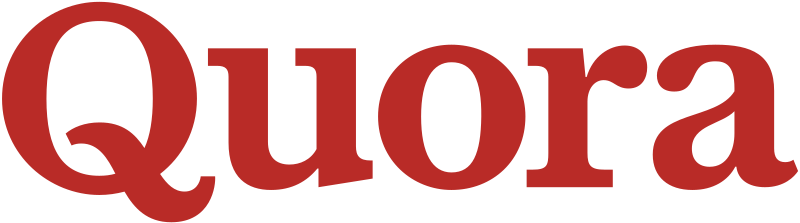


# Capstone III: Quora Question Pairs

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


Identify which questions asked on Quora are duplicates of questions that have already been asked.
This could be useful to instantly provide answers to questions that have already been answered.
We are tasked with predicting whether a pair of questions are duplicates or not.

# 1. Data Wrangling and EDA

In [54]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import regex as re

from fuzzywuzzy import fuzz

import spacy
nlp= spacy.load('en_core_web_md')
from spacy.tokens import Doc, Span

import distance

import wordcloud

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import jaccard_score

# from sentence_transformers import SentenceTransformer, util

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords

from transformers import BertTokenizer, BertModel
import torch

import editdistance
%matplotlib inline

from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
plt.style.use('ggplot')

## 1.1 Reading Data and Basic Stats

In [40]:
train= pd.read_csv(r"C:\Users\sina\Documents\train.csv")
display(train.head())
print(train.info())

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None


We are given a minimal number of data fields here, consisting of:

* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

### 1.2.1 Distribution of Data Among DIfferent Output Classes
- Number of duplicate(smilar) and non-duplicate(non similar) questions

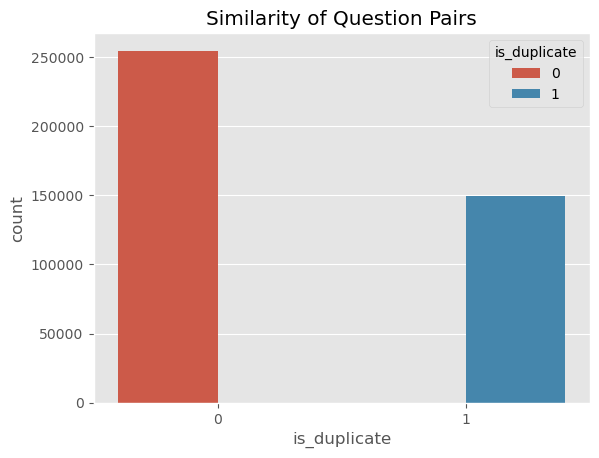

Total number of question pairs for training: 404290
Questions that are similar: 36.92%


In [41]:
sns.countplot(data=train, x='is_duplicate', hue= 'is_duplicate')
plt.title('Similarity of Question Pairs')
plt.show()

print(f'Total number of question pairs for training: {len(train)}\nQuestions that are similar: {100*train.is_duplicate.value_counts(normalize=True)[1]:.2f}%')

In [42]:
train.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

### 1.2.2 Checking for Missing Values

In [43]:
# Check if there is missing values in a ny of the rows
print(train.isna().sum(), '\n')

# Show the rows with missing values
display(train.loc[train.isna().any(axis=1)])

# It does not help with the prediction, therefore we remove the rows with missing values
print(f"The current dataset has {len(train)} rows")

train.dropna(how='any', inplace=True)
print(f"The new dataset has {len(train)} rows")

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64 



,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


The current dataset has 404290 rows
The new dataset has 404287 rows


### 1.2.3 Number of Unique Questions

Total number of uniques questiona are: 537359
Number of unique questions that appear more than once: 271215, which is about 33.54% of the total questions
(808574, 2) 

(649229, 2)


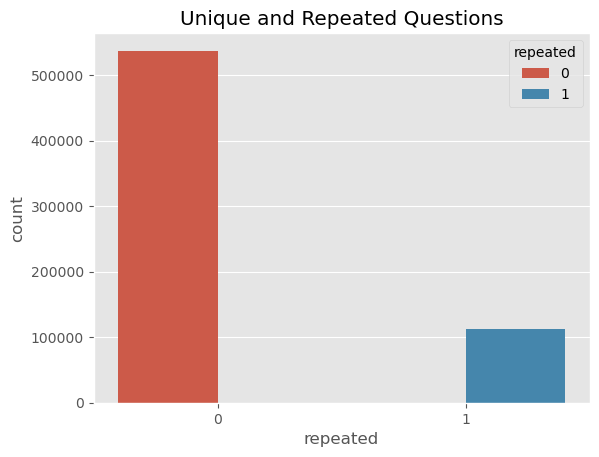

In [44]:
# All the questions
questions= pd.concat(objs=[train.question1, train.question2])
print(f"Total number of uniques questiona are: {len(set(questions))}")

# Number of repeated questions
print(f"Number of unique questions that appear more than once: {questions.duplicated(keep='first').sum()}, which is about {100*questions.duplicated().sum()/len(questions):.2f}% of the total questions")

# Plotting
repeated= questions.duplicated().astype(int)
questions_df= pd.DataFrame({'questions': questions, 'repeated':repeated})
print(questions_df.shape, '\n')

# Drop the duplicated questions and keep the duplication identifier column
questions_df.drop_duplicates(inplace=True)
print(questions_df.shape)

sns.countplot(x='repeated', data= questions_df, hue= 'repeated')
plt.title('Unique and Repeated Questions')
plt.show()

### 1.2.4 Checking for Duplicates

In [45]:
#checking whether there are any repeated pair of questions

pair_duplicates= train.loc[train.question1 == train.question2]
print(len(pair_duplicates))

0


### 1.2.5 Number of occurrences of each question

The most common questions are:
[('What are the best ways to lose weight?', 161), ("How can you look at someone's private Instagram account without following them?", 120), ('How can I lose weight quickly?', 111), ("What's the easiest way to make money online?", 88), ('Can you see who views your Instagram?', 79)]



,question,n
0,What are the best ways to lose weight?,161
1,How can you look at someone's private Instagra...,120
2,How can I lose weight quickly?,111
3,What's the easiest way to make money online?,88
4,Can you see who views your Instagram?,79


,questions,numbers
0,What is the step by step guide to invest in sh...,1
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,4
2,How can I increase the speed of my internet co...,1
3,Why am I mentally very lonely? How can I solve...,1
4,"Which one dissolve in water quikly sugar, salt...",3


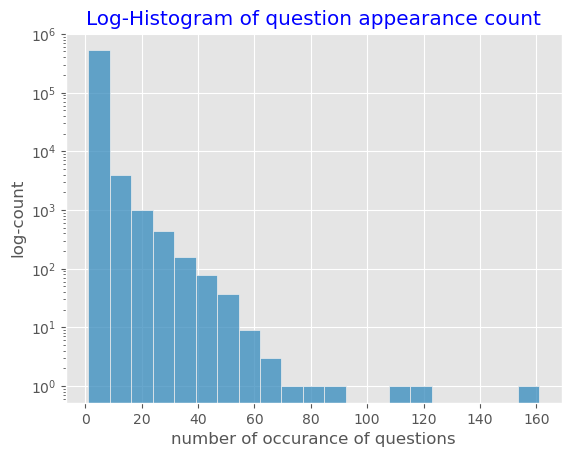

In [46]:
# Max number of repetition
from collections import Counter
print(f"The most common questions are:\n{Counter(questions).most_common(5)}\n")

display(pd.DataFrame({'question': [Counter(questions).most_common(5)[i][0] for i in range(5)], 
             'n': [Counter(questions).most_common(5)[i][1] for i in range(5)]}))

# *********
dict_counter= dict(Counter(questions))

questions_count_df= pd.DataFrame({'questions': dict_counter.keys(), 'numbers': dict_counter.values()})
display(questions_count_df.head())

sns.histplot(data= questions_count_df, x= 'numbers')
plt.yscale('log')
plt.xlabel('number of occurance of questions')
plt.ylabel('log-count')
plt.title('Log-Histogram of question appearance count', color= 'b')
plt.show()

In [47]:
import spacy

nlp= spacy.load('en_core_web_sm')

def qlen(doc):
    return len(doc)

Doc.set_extension('question_length', method= qlen, force= True)
doc= nlp('How can I develop android app?')
print(doc._.question_length())

7


## 1.3 Basic Feature Extraction (Before Cleaning)

Let us now construct a few features like:

____freq_qid1____ = Frequency of qid1's in the 'question1' column

____freq_qid2____ = Frequency of qid2's in the 'question2' column

____freq_qid1_total____ = Frequency of qid1's in all questions combined

____freq_qid2_total____ = Frequency of qid2's in all questions combined

____q1len____ = Length of q1

____q2len____ = Length of q2

____q1_n_words____ = Number of words in Question 1

____q2_n_words____ = Number of words in Question 2

____word_Common____ = (Number of common unique words in Question 1 and Question 2)

____word_Total____ = UNIQUE (Total num of words in Question 1 + Total num of words in Question 2)

____word_share____ = (word_common)/(word_Total)

____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2

____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

In [48]:
train['freq_qid1']= train.groupby('question1')['question1'].transform('size')
train['freq_qid2']= train.groupby('question2')['question2'].transform('size')

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1


In [49]:
count_list=[]
for row_tuple in train.itertuples():
    try:
        count_list.append(dict_counter[row_tuple.question1])
    except:
        count_list.append(0)

train['freq_qid1_total']= count_list


count_list=[]
for row_tuple in train.itertuples():
    try:
        count_list.append(dict_counter[row_tuple.question2])
    except:
        count_list.append(0)
        
train['freq_qid2_total']= count_list

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,4,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,1,1


In [50]:
train['q1len']= train.question1.str.len()
train['q2len']= train.question2.str.len()

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,1,1,66,57
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,4,2,51,88
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,1,1,73,59


In [51]:
train['q1_n_words']= train.question1.apply(lambda x: len(x.split()))
train['q2_n_words']= train.question2.apply(lambda x: len(x.split()))

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,4,2,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,1,1,73,59,14,10


In [52]:
def word_common(df, col1, col2):
    df[col1]=df[col1].str.lower()
    df[col2]= df[col2].str.lower()

    return df.apply(lambda x: len(set.intersection(set(x[col1].split()), set(x[col2].split()))), axis=1)

train['word_Common']= word_common(train, 'question1', 'question2')

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len,q1_n_words,q2_n_words,word_Common
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,1,1,66,57,14,12,10
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,4,2,51,88,8,13,4
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,1,1,73,59,14,10,4


In [53]:
def unique_word_total(df, col1, col2):
    return df.apply(lambda x: len(set(x[col1].split())) + len(set(x[col2].split())), axis=1)

train['word_Total']= unique_word_total(train, 'question1', 'question2')

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,1,1,66,57,14,12,10,23
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,4,2,51,88,8,13,4,20
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,1,1,73,59,14,10,4,24


In [54]:
train['word_share']= train['word_Common']/train['word_Total']

In [55]:
train['freq_q1+freq_q2']= train['freq_qid1'] + train['freq_qid2']

In [56]:
train['freq_q1-freq_q2']= (train['freq_qid1'] - train['freq_qid2']).abs()

In [57]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,4,2,51,88,8,13,4,20,0.200000,5,3


### 1.3.1 Analysis of some of the extracted features

In [58]:
print('Minimum length of the question in question1 is:', train['q1_n_words'].min())
print('Minimum length of the question in question2 is:', train['q2_n_words'].min(), '\n')

print ("Number of Questions with minimum length [question1] :", train[train['q1_n_words']== 0].shape[0])
print ("Number of Questions with minimum length [question2] :", train[train['q2_n_words']== 0].shape[0], '\n')

print ("Number of Questions with minimum length [question1] :", train[train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train[train['q2_n_words']== 1].shape[0])

Minimum length of the question in question1 is: 1
Minimum length of the question in question2 is: 1 

Number of Questions with minimum length [question1] : 0
Number of Questions with minimum length [question2] : 0 

Number of Questions with minimum length [question1] : 69
Number of Questions with minimum length [question2] : 25


#### 1.3.1.1 Feature: word_share

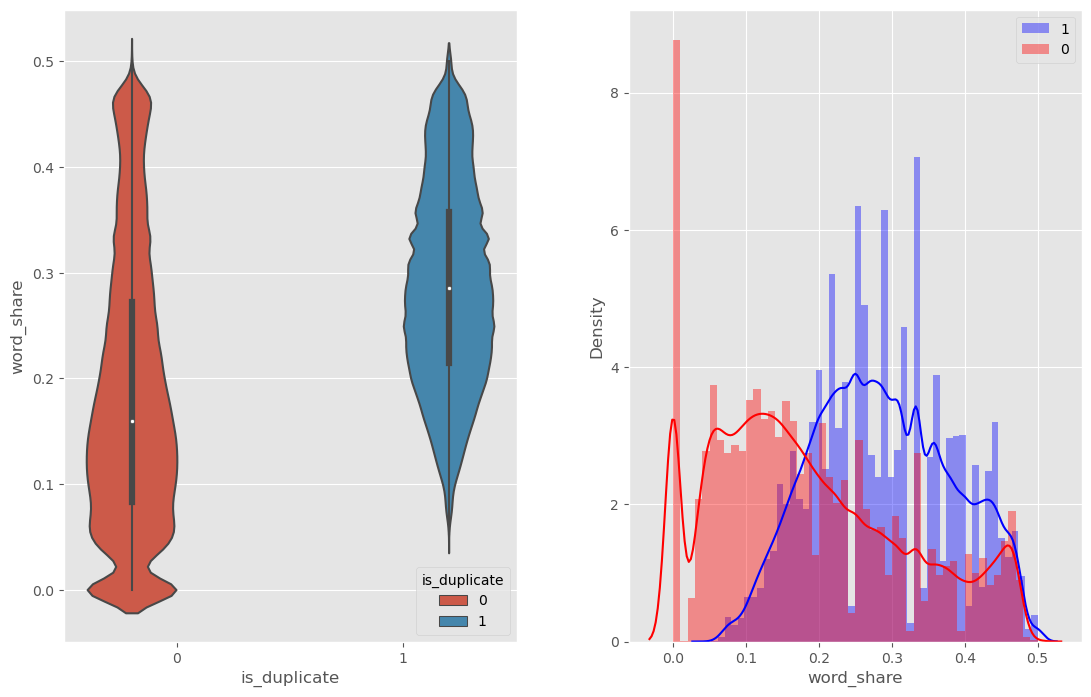

In [59]:
fig, ax= plt.subplots(1,2, figsize= (12, 8))

fig.tight_layout(pad=5.0)

plt.subplot(1,2,1)
sns.violinplot(data= train, x= 'is_duplicate', y= 'word_share', hue='is_duplicate', ax=ax[0])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'blue')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'red')
ax[1].legend()

- The median of word_share is greater when pair of questions are similar.
- The variability of word_share is higher when pair of questions are dissimilar.
- The distributions for normalized word_share have some overlap on the far right-hand side, suggesting that there are quite a lot of questions with high word similarity

#### 1.3.1.2 Feature: word_common

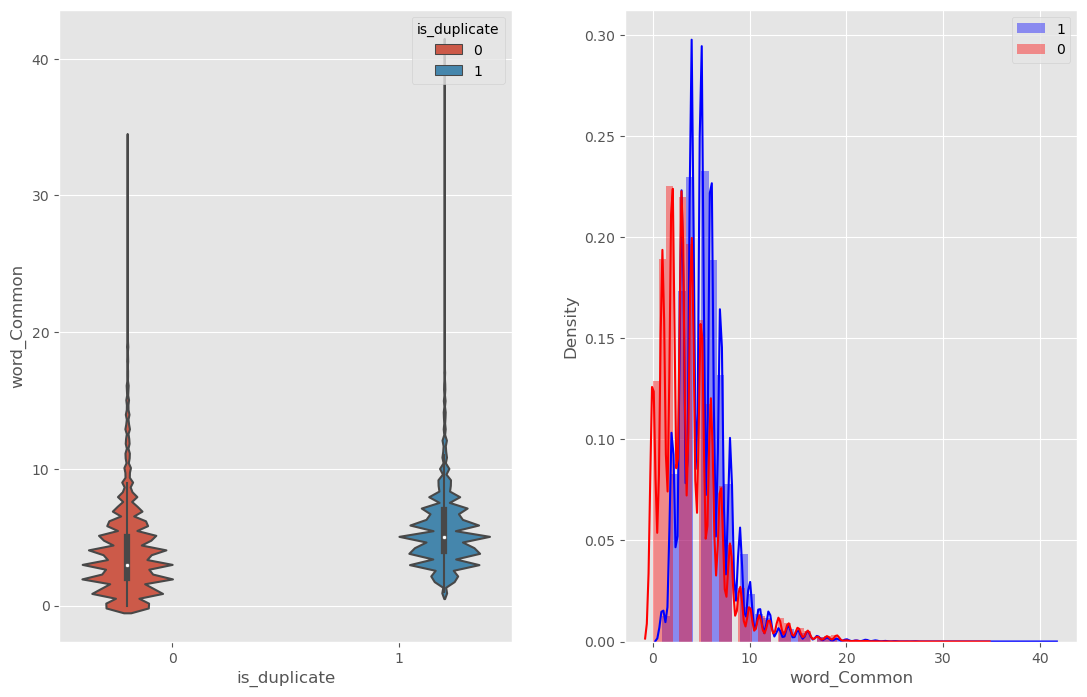

In [60]:
fig, ax= plt.subplots(1,2, figsize= (12, 8))

fig.tight_layout(pad=5.0)

plt.subplot(1,2,1)
sns.violinplot(data= train, x= 'is_duplicate', y= 'word_Common', hue= 'is_duplicate', ax=ax[0])

plt.subplot(1,2,2)
sns.distplot(train.loc[train['is_duplicate']==1, 'word_Common'], label= '1', kde= True, ax=ax[1], color= 'blue')
sns.distplot(train.loc[train['is_duplicate']==0, 'word_Common'], label= '0', kde= True, ax=ax[1], color= 'red')
ax[1].legend()
plt.show()

- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping
- When comparing with word_share, word_share is a better factor to be included in the model

## 1.4 Preprocessing of Text

* **Preprocessing:**
    - Lowercasing
    - Manual replacement

In [61]:
def preprocess(q):
    
    # Lowercasing
    q = str(q).lower()
    
    
    # Manual Replacement
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    
    return q

In [62]:
train['question1_pp']= train.question1.apply(preprocess)

In [63]:
train['question2_pp']= train.question2.apply(preprocess)

## 1.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:

Token: You get a token by splitting sentence a space\
Stop_Word : stop words as per NLTK.\
Word : A token that is not a stop_word\
Features:

- __cwc_min__ : Ratio of common_word_count to min length of word count of Q1 and Q2\
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


- __cwc_max__ : Ratio of common_word_count to max length of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

- __csc_min__ : Ratio of common_stop_count to min length of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

- __csc_max__ : Ratio of common_stop_count to max length of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

- __ctc_min__ : Ratio of common_token_count to min length of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

- __ctc_max__ : Ratio of common_token_count to max length of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


- __last_word_eq__ : Check if Last word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


- __first_word_eq__ : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])


- __abs_len_diff__ : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


- __mean_len__ : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2


- __fuzz_ratio__ 

- __fuzz_partial_ratio__ 

- __token_sort_ratio__ 

- __token_set_ratio__ 

- __longest_substr_ratio__ : Ratio of length longest common substring to min length of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens)

### TFIDF and Cosine Similarity: This Cosine similarity is different as it is based on the tfidf vectors
**There are two ways of doing it:**
- 1) Concatenate question1 and question2 in each row and find the tfidf and cosine similarities for the combined column
- 2) Find the tfidf and cosine similarity for each row separately

TF-IDF (Term Frequency-Inverse Document Frequency) similarity is a metric used to quantify the similarity between two documents or pieces of text based on the words they contain. TF-IDF takes into account the frequency of terms (words) in a document relative to their frequency across a collection of documents. It is commonly used in information retrieval and text mining.

Here's how TF-IDF similarity is calculated:

**1) Term Frequency (TF):**
Term Frequency measures how often a term (word) appears in a document. It is calculated as the ratio of the number of times a term occurs in a document to the total number of terms in the document. The idea is to give higher weight to terms that appear more frequently in the document.


**2) Inverse Document Frequency (IDF):**
Inverse Document Frequency measures the importance of a term in the entire collection of documents. It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the term. The idea is to give higher weight to terms that are less common across all documents.
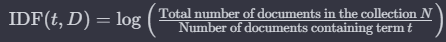

**3) TF-IDF Score:**
The TF-IDF score for a term in a document is the product of its Term Frequency and Inverse Document Frequency.


**4) TF-IDF Similarity:**
TF-IDF Similarity between two documents (or pieces of text) is calculated as the cosine similarity between their TF-IDF vectors. The TF-IDF vectors represent the documents in a high-dimensional space, where each dimension corresponds to a unique term.
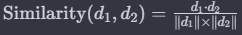
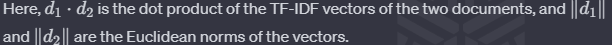

### Levenshtein Distance
Levenshtein distance, also known as edit distance, is a measure of the similarity between two strings by calculating the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one string into the other. In the context of Levenshtein distance or similar string similarity metrics, lower values indeed indicate greater similarity.

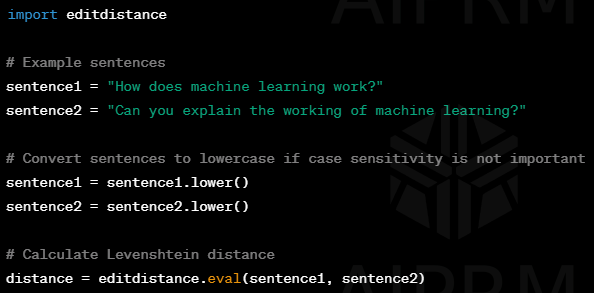

### Jaccard Similarity:
Jaccard Similarity is a measure of similarity between two sets. It's defined as the size of the intersection of the sets divided by the size of the union of the sets. The Jaccard Similarity is often used in the context of comparing the similarity between two sets of elements, such as words, tokens, or documents.
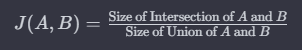
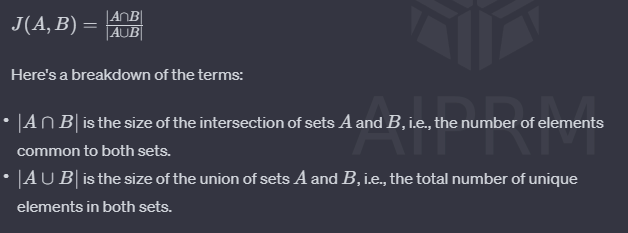

The Jaccard Similarity ranges from 0 to 1, where 0 means no similarity (no common elements) and 1 means complete similarity (all elements are the same). It provides a way to quantify the similarity between sets irrespective of the order or frequency of elements.

Jaccard Similarity is commonly used in various applications, including text mining, information retrieval, and recommendation systems, where measuring the similarity between sets of items is important.

**With the other features, there is no need to compute the Jaccard similarity here**

In [64]:
vectorizer= TfidfVectorizer(lowercase= True, stop_words='english')


Levenshtein distance, also known as edit distance, is a measure of the similarity between two strings by calculating the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one string into the other.

In [65]:
def get_features(q1, q2):
    
    features=[]
    
    # Converting sentences (rows) into tokens
    q1_tokens= word_tokenize(q1)
    q2_tokens= word_tokenize(q2)
    
    # Remove the stop words from the tokens and create the unique words
    q1_words= set([word for word in q1_tokens if word not in stopwords.words('english')])
    q2_words= set([word for word in q2_tokens if word not in stopwords.words('english')])
    
    # Get the stop words in questions
    q1_stops= set([word for word in q1_tokens if word in stopwords.words('english')])
    q2_stops= set([word for word in q2_tokens if word in stopwords.words('english')]) 
    
    # Get the # common non-stop words from question pair
    common_word_count= len(set.intersection(q1_words, q2_words))
    
    # Get the common stop words from question pair
    common_stop_count= len(set.intersection(q1_stops, q2_stops))
     
    # Get the comon tokens from question pair
    common_token_count= len(set.intersection(set(q1_tokens), set(q2_tokens)))
    
    ####
    
    # In order to not divide the numbers by ZERO we add a saf_div variable to the denominators
    safe_div = 0.0001 
    
    # Ratio of common_word_count to min lenghth of word count of Q1 and Q2
    features.append(round(common_word_count/(min(len(q1_words), len(q2_words))+safe_div), 6))
    # Ratio of common_word_count to max lenghth of word count of Q1 and Q2
    features.append(round(common_word_count/(max(len(q1_words), len(q2_words))+safe_div), 6))
    
    # Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
    features.append(round(common_stop_count/(min(len(q1_stops), len(q2_stops))+safe_div), 6))
    # Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
    features.append(round(common_stop_count/(max(len(q1_stops), len(q2_stops))+safe_div), 6))
    
    # Ratio of common_token_count to min lenghth of token count of Q1 and Q2
    features.append(round(common_token_count/(min(len(q1_tokens), len(q2_tokens))+safe_div), 6))
    features.append(round(common_token_count/(max(len(q1_tokens), len(q2_tokens))+safe_div), 6))

   ####

    try:
        # Check if Last word of both questions is equal or not
        features.append(int(q1_tokens[-1]==q2_tokens[-1]))
    
        # Check if First word of both questions is equal or not
        features.append(int(q1_tokens[0]==q2_tokens[0]))
    except:
        features.append(int(False))
        features.append(int(False))
    
    ####
    
    # Absolute length difference
    features.append(abs(len(q1_tokens)-len(q2_tokens)))
    
    # Average token length of both questions
    features.append(np.mean([len(q1_tokens),len(q2_tokens)]))
    
    #### SIMILARITIES
    
    # 1: Find the similarity: Cosine similarity
    features.append(nlp(q1).similarity(nlp(q2)))
    
    # 2: Separate TF-IDF matrices for each pair
    try:
        tfidf_array= vectorizer.fit_transform([q1, q2]).toarray()
        tfidf_vector1 = tfidf_array[0]
        tfidf_vector2 = tfidf_array[1]
    
        max_length = max(len(tfidf_vector1), len(tfidf_vector2))
        tfidf_vector1 = np.pad(tfidf_vector1, (0, max_length - len(tfidf_vector1)), mode='constant')
        tfidf_vector2 = np.pad(tfidf_vector2, (0, max_length - len(tfidf_vector2)), mode='constant')
        features.append(cosine_similarity([tfidf_vector1], [tfidf_vector2])[0][0])
    except:
        features.append(0)
    
    # 3: Levenshtein Distance
    features.append(editdistance.eval(q1, q2))
    
    # 4: Jaccard Similarity
    #features.append(jaccard_score(list(set1), list(set2)))
    
    # Fuzzy partial ratio
    features.append(fuzz.partial_ratio(q1, q2))
    # Token sort ratio
    features.append(fuzz.token_sort_ratio(q1, q2))
    # token set ratio
    features.append(fuzz.token_set_ratio(q1, q2))
    
    return features

In [66]:
features= train.apply(lambda x: get_features(x['question1_pp'], x['question2_pp']), axis=1)

In [67]:
x=[]
for i in range(len(features[0])):
    x.append(features.apply(lambda x: x[i]))

In [68]:
features_df= pd.DataFrame({'cwc_min': x[0], 'cwc_max': x[1], 'csc_min': x[2], 'csc_max': x[3], 'ctc_min': x[4], 
                           'ctc_max': x[5], 'last_word_eq': x[6], 'first_word_eq': x[7], 'abs_len_diff': x[8],
                           'mean_len': x[9], 'cos_sim': x[10], 'cos_sim_tfidf': x[11], 'Levenshtein_dist': x[12],
                           'fuzzy_partial_ratio': x[13], 'token_sort_ratio': x[13], 'token_set_ratio': x[14]})

In [69]:
train= pd.concat([train, features_df], axis=1)

### Longest Substring Ratio

In [70]:
docs1= list(nlp.pipe(train.question1_pp))
docs2= list(nlp.pipe(train.question2_pp))

In [71]:
safe_div = 0.0001 

min_len= lambda x, y: min(len(x), len(y))
min_token_len= [min_len(x, y)+safe_div for x, y in zip(docs1, docs2)]

In [72]:
lssr= []
for idx, row in train.iterrows():
    lssr.append(list(distance.lcsubstrings(row['question1_pp'], row['question2_pp'])))

In [73]:
train['longest_substr_ratio']= [len(lssr[i][0].split())/min_token_len[i] if len(lssr[i])!=0 else 0 for i in range(len(lssr))]

### Bert Embedding:

BERT (Bidirectional Encoder Representations from Transformers) is a powerful pre-trained natural language processing (NLP) model developed by Google. BERT embeddings refer to the vector representations of words or sentences generated by the BERT model. These embeddings capture rich semantic information about the input text and are often used for various NLP tasks, including calculating the similarity between two sentences.

To use BERT embeddings for sentence similarity, you can follow these general steps:

Tokenization: Break down each sentence into its constituent words or subwords. BERT uses WordPiece tokenization, which may break down words into smaller subword units.

Padding and Truncation: Ensure that the input sequences have a consistent length. You may need to pad shorter sequences or truncate longer ones to fit the model's input size.

Conversion to Embeddings: Feed the tokenized and processed sentences into the BERT model, and obtain the embeddings for each token. In the case of sentence similarity, you often use the embedding of the [CLS] (classification) token, which is typically located at the beginning of the output sequence.

Similarity Calculation: Use a similarity metric (e.g., cosine similarity) to measure the similarity between the obtained embeddings of the two sentences.

Here's a simplified example using the transformers library in Python, which provides an easy interface to use pre-trained BERT models:

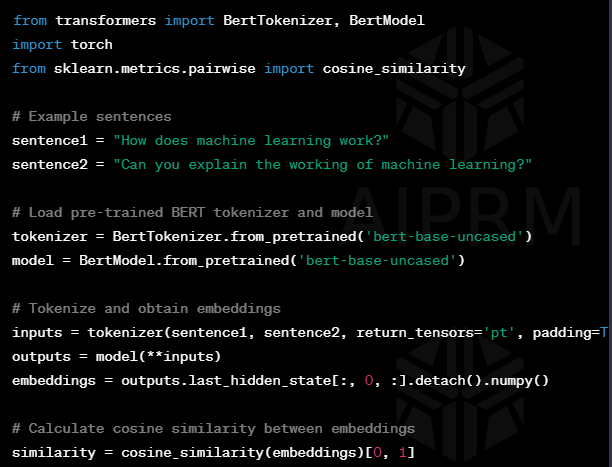


The BertTokenizer is used to tokenize the sentences.
The BertModel is loaded to obtain the embeddings.
The [CLS] token embedding is extracted and used for calculating the cosine similarity between the two sentences.

! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
model= BertModel.from_pretrained('bert-base-uncased')

### Function to get BERT embeddings for two columns in a row
def get_bert_embeddings(row):
    # Concatenate the text from two columns
    text = f"{row['question1_pp']} {row['question2_pp']}"

    # Tokenize input text
    tokens = tokenizer(text, return_tensors='pt')

    # Forward pass through BERT model
    with torch.no_grad():
        outputs = model(**tokens)

    # Extract embeddings from the output
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

### Apply BERT embeddings to each row
train['bert_embeddings'] = train.apply(get_bert_embeddings, axis=1)

cosine_similarity(train['bert_embeddings'][:1000].tolist()).diagonal()

**<span style= "color: red"> Cosine similarity with Bert embedding is not providing any valuable info</span>**

### Word Embedding

First, remove the rows with missing values or zero text length

train=train.loc[np.logical_and(train.question1.str.len()!=0, train.question2.str.len()!=0)]

from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
### Load a pre-trained Word2Vec model (Word2Vec Google News vectors)
model = api.load('word2vec-google-news-300')

model.index_to_key[:100]

#[model[word] for word in train['question1'].str.split()[0] if word in model.index_to_key]

word_vectors=lambda x: [model[word] if word in model.index_to_key else 0 for word in x]
word_vectors_list1=train['question1'].apply(word_vectors)

### The output is a list of vectors for each question, for which we want to turn into one vector 
### of means

word_vectors_list2=train['question2'].apply(word_vectors)

from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np

### Load a pre-trained Word2Vec model (Word2Vec Google News vectors)
model = api.load('word2vec-google-news-300')

def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model.index_to_key]
    
    if not word_vectors:
        return None  # No valid word vectors found
    
    return np.mean(word_vectors, axis=0)

### Example sentences
sentence1 = "The cat in the hat."
sentence2 = "A dog wearing a hat."

### Calculate sentence vectors
vector1 = sentence_vector(sentence1, model)
vector2 = sentence_vector(sentence2, model)

### Check if valid vectors were obtained
if vector1 is not None and vector2 is not None:
    # Calculate cosine similarity between sentence vectors
    similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    print(f"Similarity between sentences:\n'{sentence1}'\nand\n'{sentence2}': {similarity}")
else:
    print("One or both sentences contain no valid word vectors.")

train['word_embedding_similarity']= word_embedding_similarity

In [74]:
train.to_csv('train_new.csv', index= None)

## <span style="color:green">The data is saved in a csv file, import the saved data and continue working on that

## 1.6 Analysis of extracted features

### 1.6.1 Create word clouds

In [3]:
# Import the preprocessed data:
train= pd.read_csv('train_new.csv')

In [4]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,...,first_word_eq,abs_len_diff,mean_len,cos_sim,cos_sim_tfidf,Levenshtein_dist,fuzzy_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,1,1,...,1,2,13.0,0.954680,0.895532,9,100,100,93,0.999992
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,4,2,...,1,5,12.5,0.757017,0.474331,42,74,74,63,0.416663


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    404287 non-null  int64  
 1   qid1                  404287 non-null  int64  
 2   qid2                  404287 non-null  int64  
 3   question1             404287 non-null  object 
 4   question2             404287 non-null  object 
 5   is_duplicate          404287 non-null  int64  
 6   freq_qid1             404287 non-null  int64  
 7   freq_qid2             404287 non-null  int64  
 8   freq_qid1_total       404287 non-null  int64  
 9   freq_qid2_total       404287 non-null  int64  
 10  q1len                 404287 non-null  int64  
 11  q2len                 404287 non-null  int64  
 12  q1_n_words            404287 non-null  int64  
 13  q2_n_words            404287 non-null  int64  
 14  word_Common           404287 non-null  int64  
 15  

In [6]:
dup= train.loc[train.is_duplicate==1]
non_dup= train.loc[train.is_duplicate==0]

**Dubpicated & Non-duplicated corpus**

In [7]:
from spacy.lang.en import STOP_WORDS

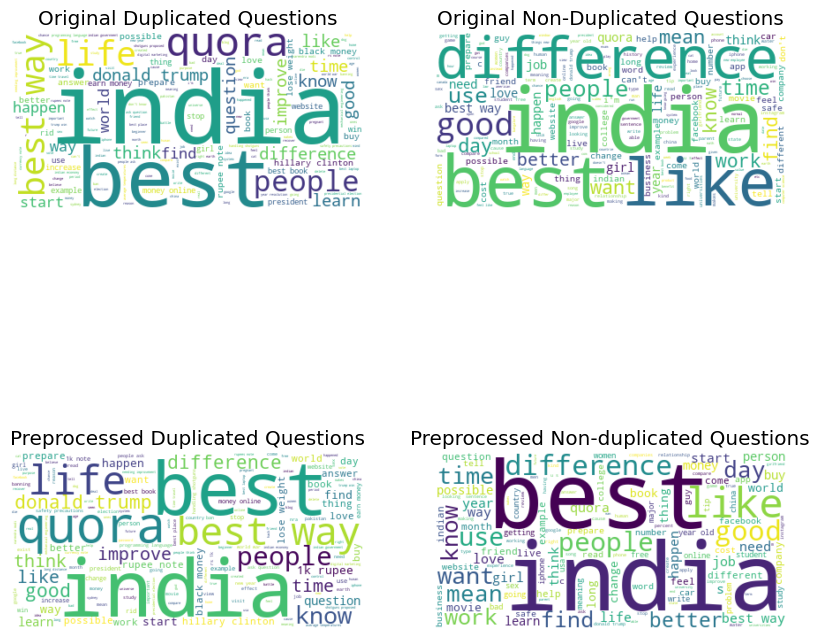

In [8]:
fig, ax= plt.subplots(2,2, figsize=(10, 10))

dup_corp= dup['question1'].str.cat(sep=' ')+' '+dup['question2'].str.cat(sep= ' ')
non_dup_corp= non_dup['question1'].str.cat(sep=' ')+' '+non_dup['question2'].str.cat(sep= ' ')

wc= wordcloud.WordCloud(background_color='white', stopwords= STOP_WORDS)
wc.generate(dup_corp)
ax[0,0].imshow(wc, interpolation= 'bilinear')
ax[0,0].axis('off')
ax[0,0].set_title('Original Duplicated Questions')

wc.generate(non_dup_corp)
ax[0,1].imshow(wc, interpolation= 'bilinear')
ax[0,1].axis('off')
ax[0,1].set_title('Original Non-Duplicated Questions')

dup_corp= dup['question1_pp'].str.cat(sep=' ')+' '+dup['question2_pp'].str.cat(sep= ' ')
non_dup_corp= non_dup['question1_pp'].str.cat(sep=' ')+' '+non_dup['question2_pp'].str.cat(sep= ' ')

wc= wordcloud.WordCloud(background_color='white', stopwords= STOP_WORDS)
wc.generate(dup_corp)
ax[1,0].imshow(wc, interpolation= 'bilinear')
ax[1,0].axis('off')
ax[1,0].set_title('Preprocessed Duplicated Questions')

wc.generate(non_dup_corp)
ax[1,1].imshow(wc, interpolation= 'bilinear')
ax[1,1].axis('off')
ax[1,1].set_title('Preprocessed Non-duplicated Questions')
plt.show()

- There is a lot of similarity in the vocabulary used in the duplicated pairs and non-duplicated pair of questions.
- The emphasis should be on analyzing the question pairs individually rather than considering the duplicated and non-duplicated batches as separate entities. 

### 1.6.2 Common words, stop wprds, and tokens

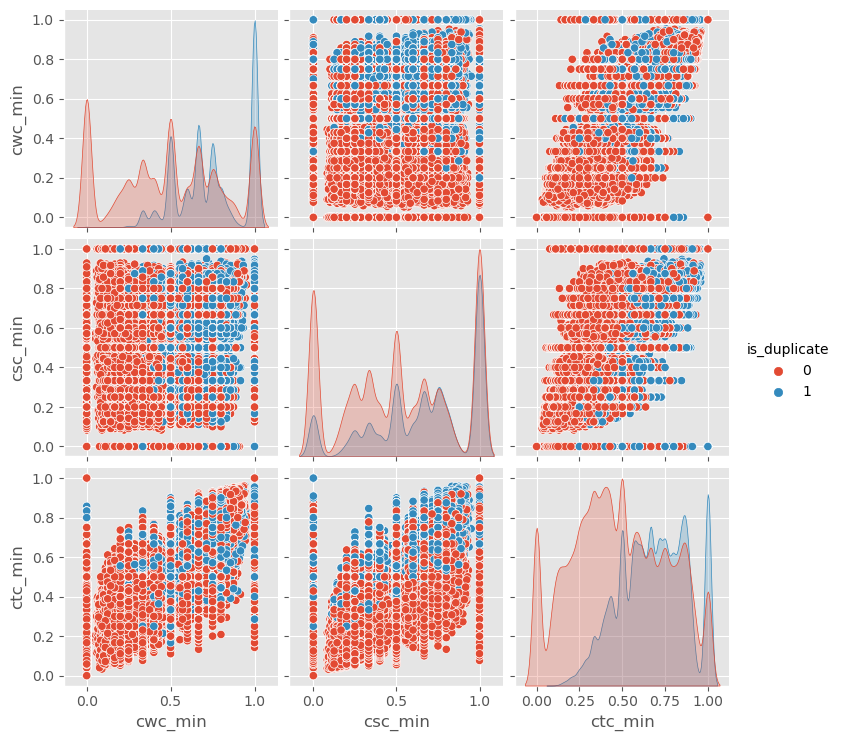

In [9]:
df_c= train[['cwc_min', 'csc_min', 'ctc_min', 'is_duplicate']]

sns.pairplot(data= df_c, hue= 'is_duplicate')

### 1.6.3 Identical first word and last word

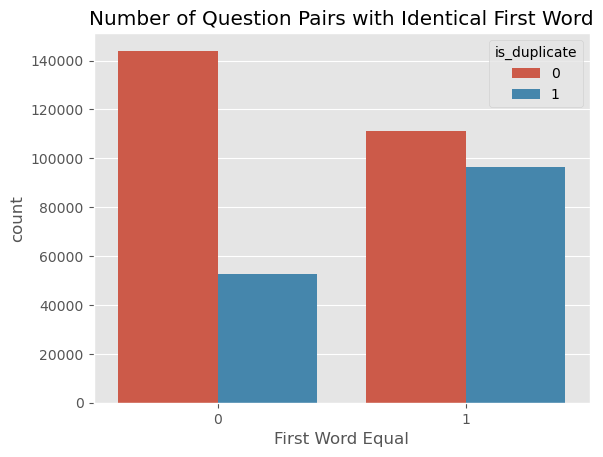

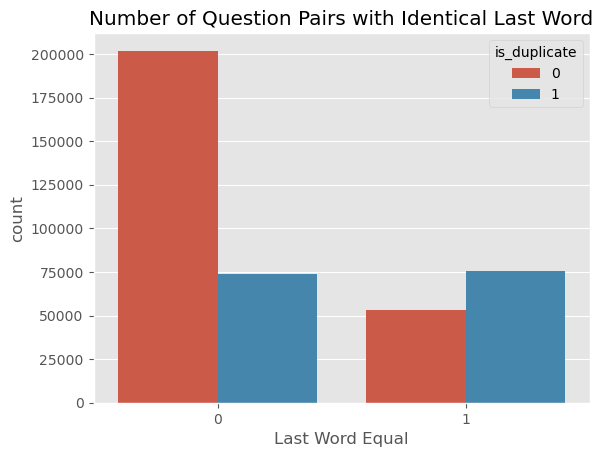

In [10]:
sns.countplot(train['first_word_eq'], fill=True, hue=train['is_duplicate'])
plt.title('Number of Question Pairs with Identical First Word')
plt.xlabel('First Word Equal')
plt.show()

sns.countplot(train['last_word_eq'], fill=True, hue=train['is_duplicate'])
plt.title('Number of Question Pairs with Identical Last Word')
plt.xlabel('Last Word Equal')
plt.show()

- It is more likely for duplicated questions to have identical last word.
- Between identical first word and last word, identical last word is more representative

### 1.6.4 Absolute length difference and average length

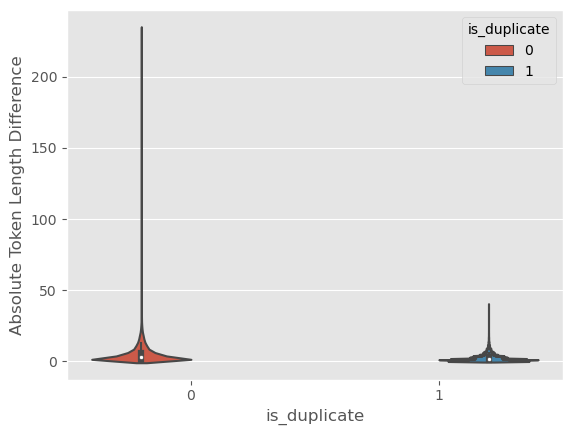

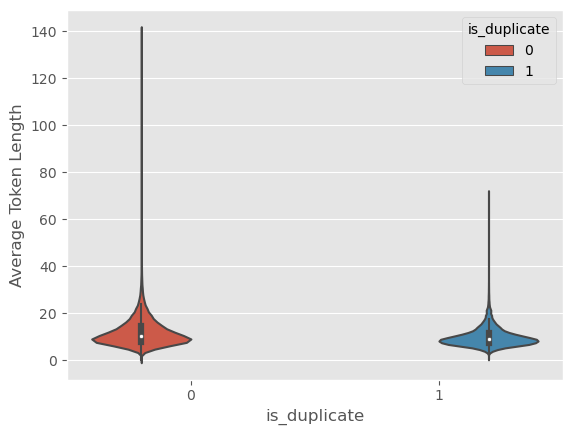

In [11]:
sns.violinplot(data=train, y='abs_len_diff', x='is_duplicate', hue= 'is_duplicate')
plt.ylabel('Absolute Token Length Difference')
plt.show()
sns.violinplot(data=train, y='mean_len', x='is_duplicate', hue= 'is_duplicate')
plt.ylabel('Average Token Length')
plt.show()

- None of them can be used for the analysis

### 1.6.5 Cosine Similarity

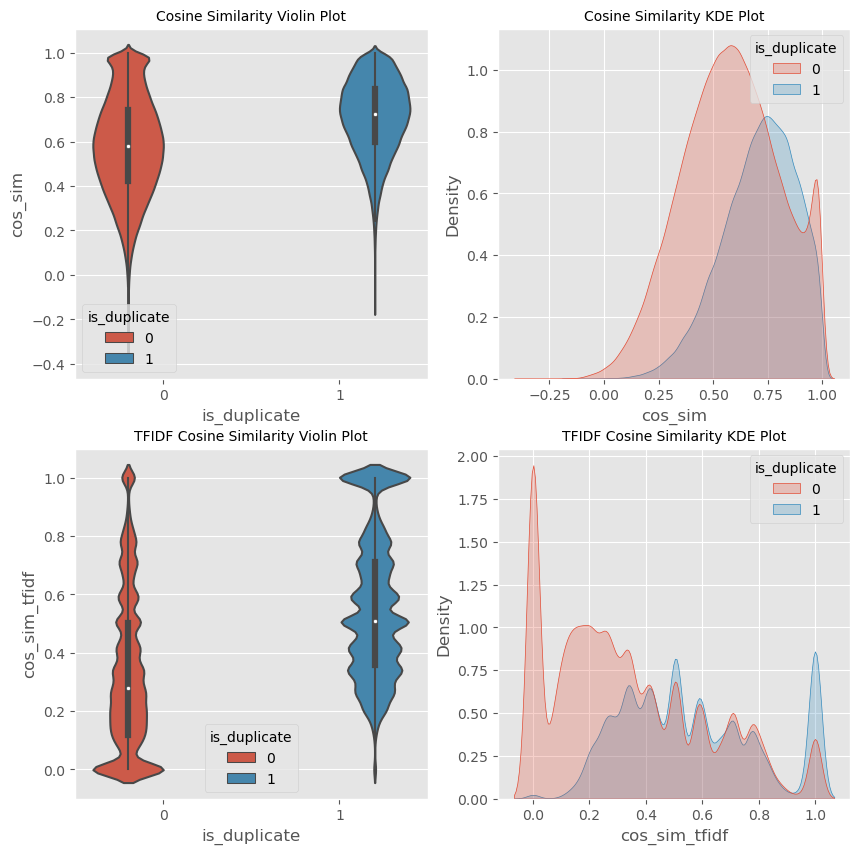

In [12]:
fig, ax= plt.subplots(2,2, figsize= (10,10))
sns.violinplot(data=train, y='cos_sim', x='is_duplicate', hue= 'is_duplicate', ax=ax[0,0])
ax[0,0].set_title('Cosine Similarity Violin Plot', size=10)
sns.kdeplot(train['cos_sim'], fill=True, hue= train['is_duplicate'], ax= ax[0,1])
ax[0,1].set_title('Cosine Similarity KDE Plot', size=10)
sns.violinplot(data=train, y='cos_sim_tfidf', x='is_duplicate', hue= 'is_duplicate', ax=ax[1,0])
ax[1,0].set_title('TFIDF Cosine Similarity Violin Plot', size=10)
sns.kdeplot(train['cos_sim_tfidf'], fill=True, hue= train['is_duplicate'], ax= ax[1,1])
ax[1,1].set_title('TFIDF Cosine Similarity KDE Plot', size=10)
plt.show()

In [13]:
pd.pivot_table(data= train, values=['cos_sim', 'cos_sim_tfidf'], columns='is_duplicate', aggfunc='describe')

is_duplicate                     0              1
cos_sim       25%         0.424209       0.599039
              50%         0.580332       0.725440
              75%         0.740573       0.836854
              count  255024.000000  149263.000000
              max         1.000000       1.000000
              mean        0.580268       0.708798
              min        -0.357825      -0.146823
              std         0.220855       0.167837
cos_sim_tfidf 25%         0.116718       0.356300
              50%         0.277396       0.510149
              75%         0.503103       0.709297
              count  255024.000000  149263.000000
              max         1.000000       1.000000
              mean        0.332154       0.560716
              min         0.000000       0.000000
              std         0.270759       0.244082

- Duplicated questions have higher cosine similarity values on average.
- The TFIDF cosine similarity is preferred for identifying duplicated questions.

### 1.6.6 Levenshtein distance

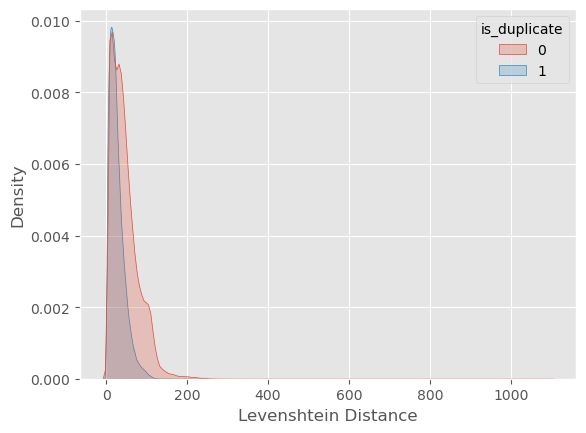

In [14]:
sns.kdeplot(train['Levenshtein_dist'], fill=True, hue= train['is_duplicate'])
plt.xlabel('Levenshtein Distance')
plt.show()

In [15]:
print(pd.pivot_table(data=train, values='Levenshtein_dist', columns='is_duplicate', aggfunc='describe'))

is_duplicate              0              1
25%               19.000000      12.000000
50%               38.000000      21.000000
75%               62.000000      35.000000
count         255024.000000  149263.000000
max             1097.000000     254.000000
mean              45.568739      25.694365
min                0.000000       0.000000
std               35.484941      19.379933


- For non-duplicate questions, the Levenshtein distance ranges from 1 to 1093, with a median value of 36, and mean value of approximately 44.37. 
- On the other hand, for duplicate questions, the Levenshtein distance ranges from 1 to 249, with a median value of 20, and mean value of around 24.73. These statistics provide insights into the distribution and central tendency of Levenshtein distances in both categories.
- Levenshtein distances for non-duplicate questions tend to have higher variability compared to duplicate questions.
- Duplicated questions have lower Levenshtein distance compared to non-duplicated questions on average

### 1.6.7 Fuzzy matching

In [16]:
def count_var_plot(var_list):
    list_len= len(var_list)
    fig, ax= plt.subplots(list_len, 2, figsize= (10,10))
    for i in range(list_len):
        sns.violinplot(data= train, x='is_duplicate', y= var_list[i], hue= 'is_duplicate', ax=ax[i,0])
        sns.kdeplot(train[var_list[i]], fill=True, hue= train['is_duplicate'], ax= ax[i,1])

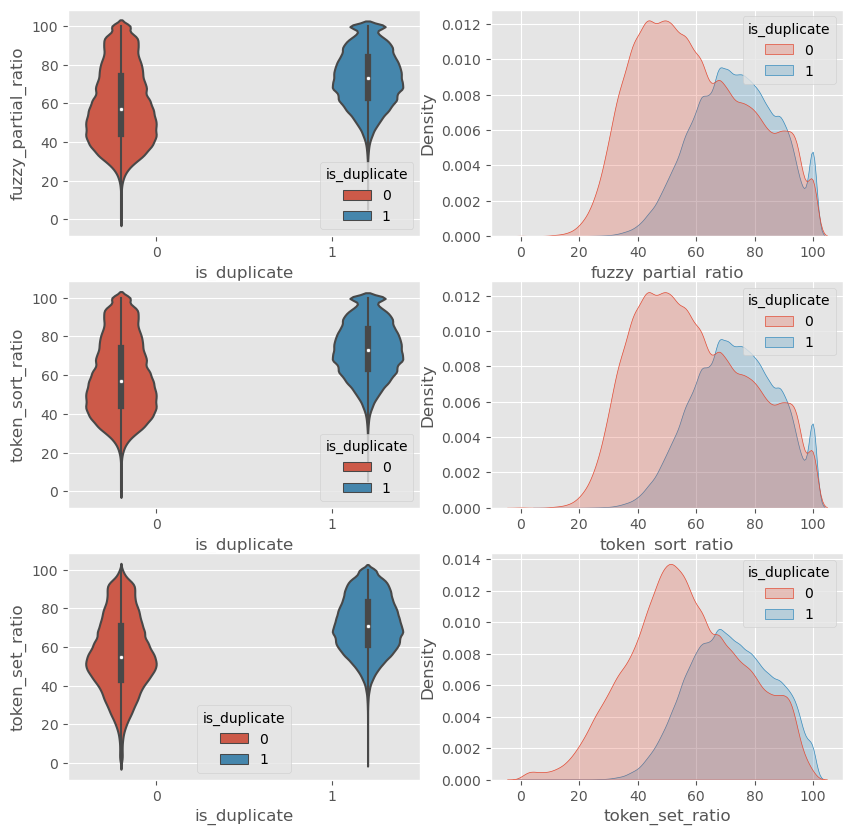

In [17]:
count_var_plot(['fuzzy_partial_ratio', 'token_sort_ratio', 'token_set_ratio'])

In [18]:
print(pd.pivot_table(data=train, values=['fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio'], columns='is_duplicate', aggfunc='describe'))

is_duplicate                           0              1
fuzzy_partial_ratio 25%        44.000000      63.000000
                    50%        57.000000      73.000000
                    75%        74.000000      84.000000
                    count  255024.000000  149263.000000
                    max       100.000000     100.000000
                    mean       59.206090      73.253365
                    min         0.000000       8.000000
                    std        19.449816      14.190807
token_set_ratio     25%        43.000000      61.000000
                    50%        55.000000      71.000000
                    75%        71.000000      83.000000
                    count  255024.000000  149263.000000
                    max       100.000000     100.000000
                    mean       56.609009      71.758601
                    min         0.000000       1.000000
                    std        19.436623      14.142645
token_sort_ratio    25%        44.000000      63

- Since the data is preprocessed, none of them is much different than another.
- Overall, duplicated questions have higher fuzzy matching values


### 1.6.8 Longest substring ratio

Text(0.5, 1.0, 'Longest Substring Ratio KDE Plot')

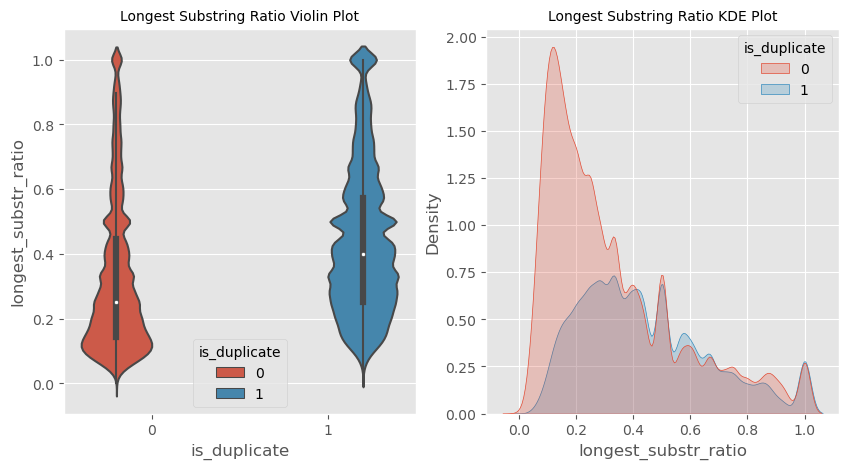

In [19]:
fig, ax= plt.subplots(1,2, figsize= (10,5))
sns.violinplot(x=train['is_duplicate'], y=train['longest_substr_ratio'], hue= train['is_duplicate'], ax=ax[0])
ax[0].set_title('Longest Substring Ratio Violin Plot', size=10)
sns.kdeplot(train['longest_substr_ratio'], fill=True, hue= train['is_duplicate'], ax= ax[1])
ax[1].set_title('Longest Substring Ratio KDE Plot', size=10)

In [20]:
print(pd.pivot_table(data= train, values='longest_substr_ratio', columns= 'is_duplicate', aggfunc='describe'))

is_duplicate              0              1
25%                0.142855       0.249998
50%                0.249997       0.399992
75%                0.444440       0.571420
count         255024.000000  149263.000000
max                0.999996       0.999996
mean               0.325339       0.440342
min                0.000000       0.031250
std                0.236549       0.227833


In [21]:
print(train.columns)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'freq_qid1_total', 'freq_qid2_total', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       'word_share', 'freq_q1+freq_q2', 'freq_q1-freq_q2', 'question1_pp',
       'question2_pp', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'cos_sim', 'cos_sim_tfidf', 'Levenshtein_dist', 'fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'longest_substr_ratio'],
      dtype='object')


# 2. Machine Learning Models

## 2.1 Data Preprocessing

#### Select the initial list of features: X

In [22]:
features=['cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'cos_sim', 'cos_sim_tfidf', 'Levenshtein_dist', 'fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'longest_substr_ratio']

print(f"The number of features:{len(features)}")

The number of features:17


### 2.1.1 Check the normality of the data

#### <span style= "color:blue">1) Histograms

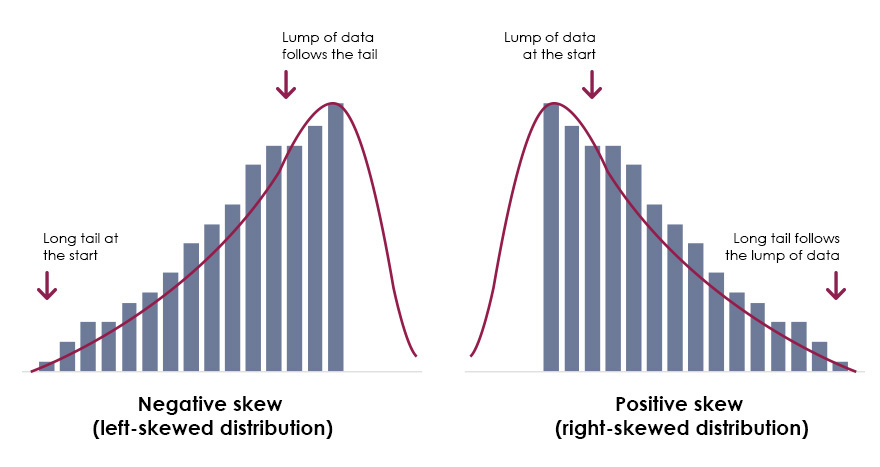

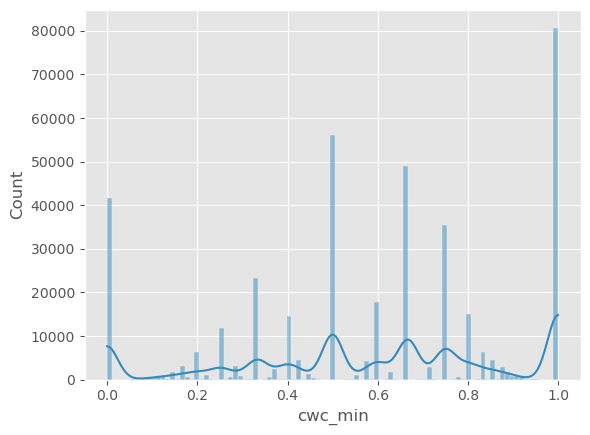

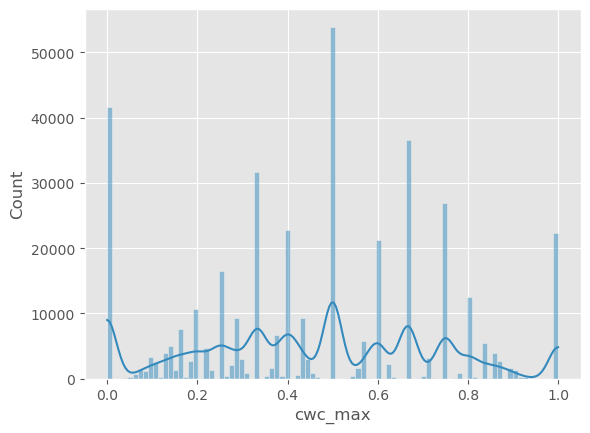

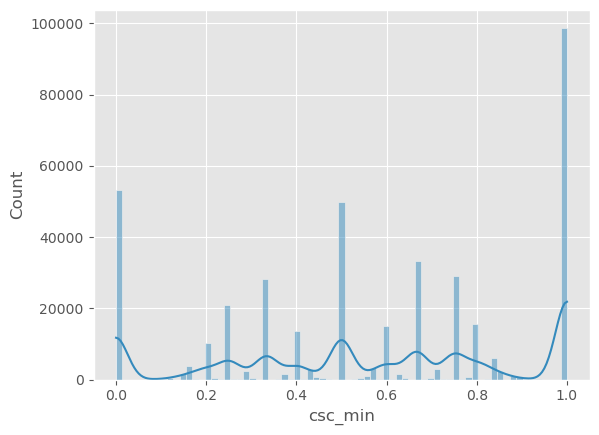

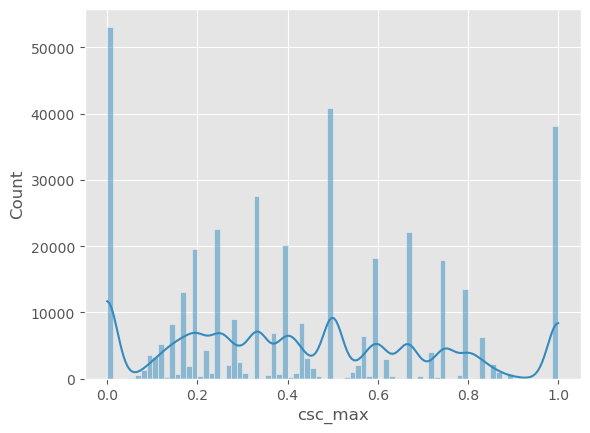

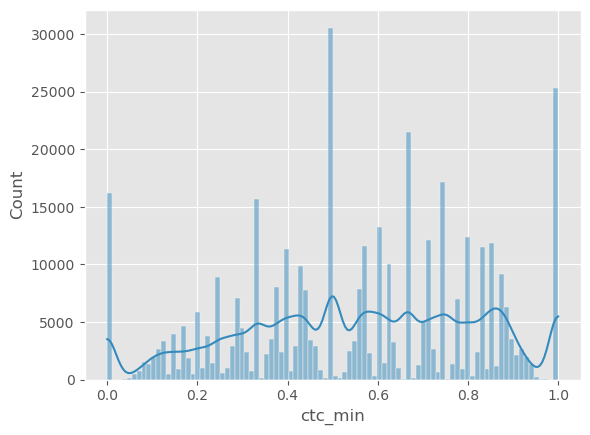

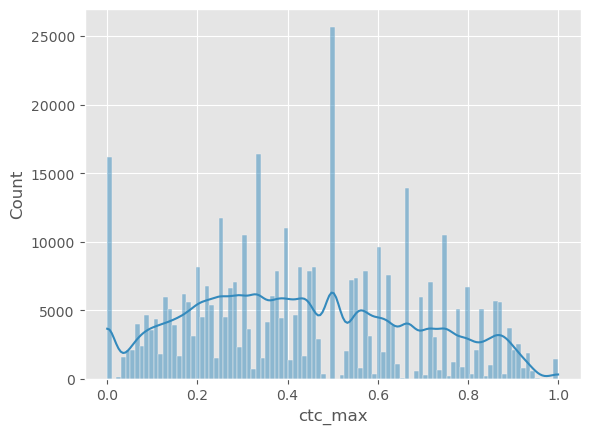

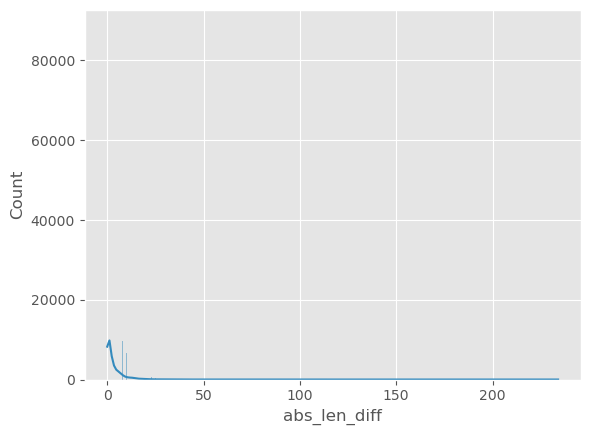

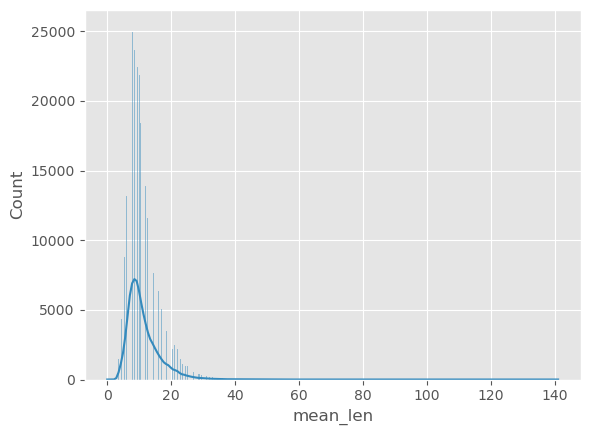

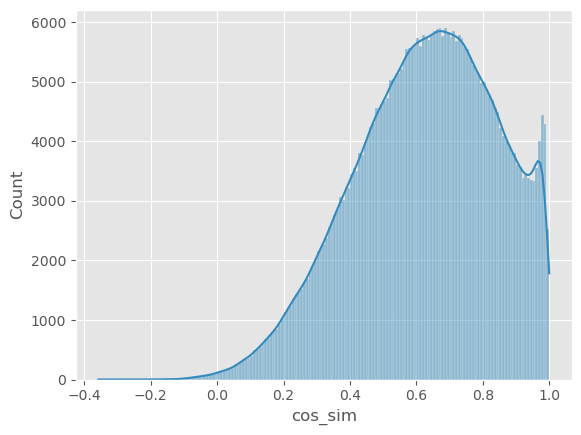

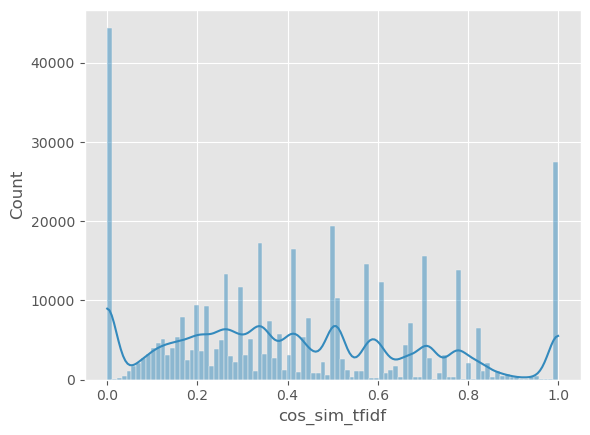

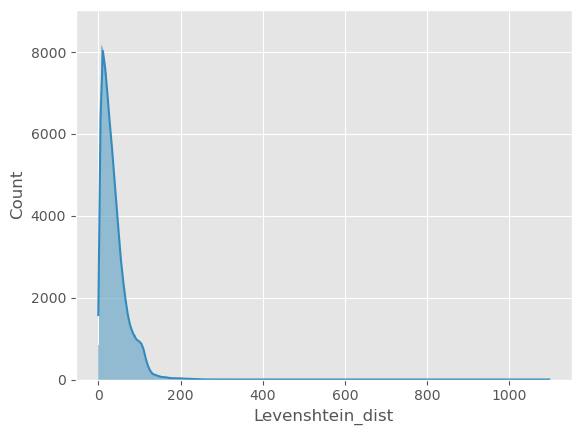

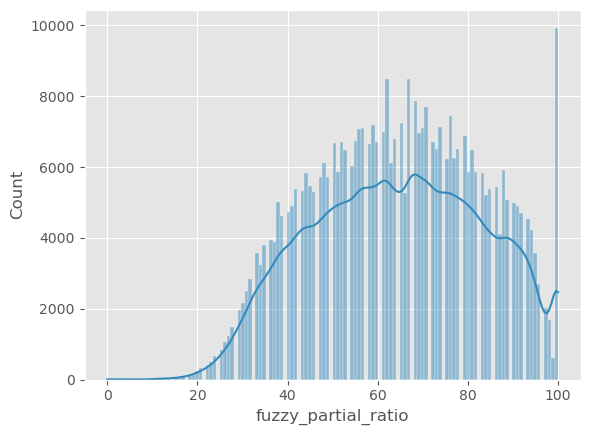

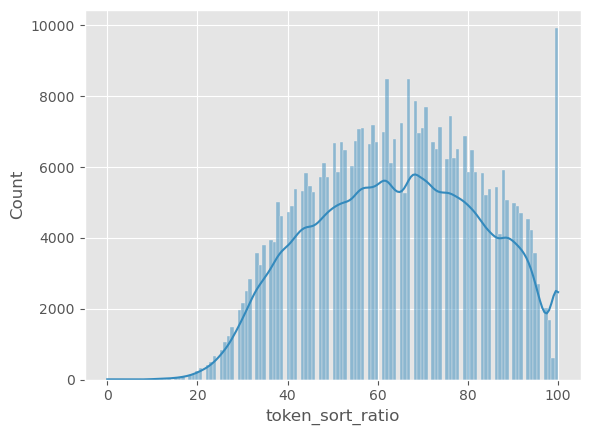

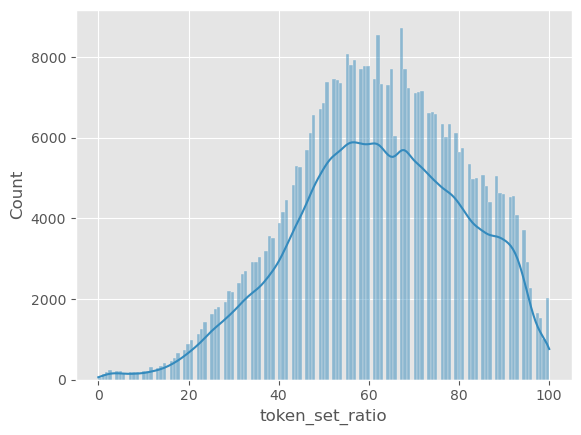

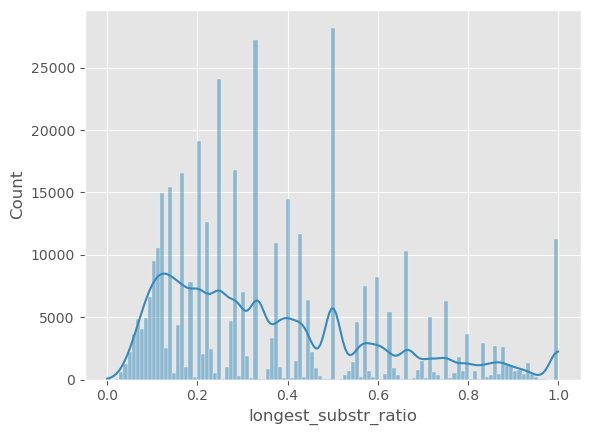

In [23]:
for feature in ['cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'abs_len_diff', 'mean_len', 'cos_sim', 'cos_sim_tfidf', 
            'Levenshtein_dist', 'fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'longest_substr_ratio']:
    sns.histplot(data= train, x= feature, kde= True)
    plt.show()

**Highlights:**
    
    1. last_word_eq and first_word_eq are binary values
    2. mean_len and lavenshtein_dist are right skewed
    3. cos_sim is left skewed

#### Log-transformation for right-skewed data

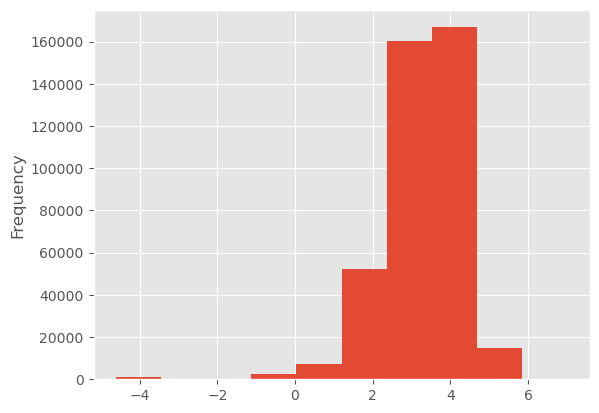

In [24]:
pseudo_count = 0.01
train['Levenshtein_dist_log']= np.log(train.Levenshtein_dist+pseudo_count)
train['Levenshtein_dist_log'].plot(kind= 'hist')
plt.show()
# Much better

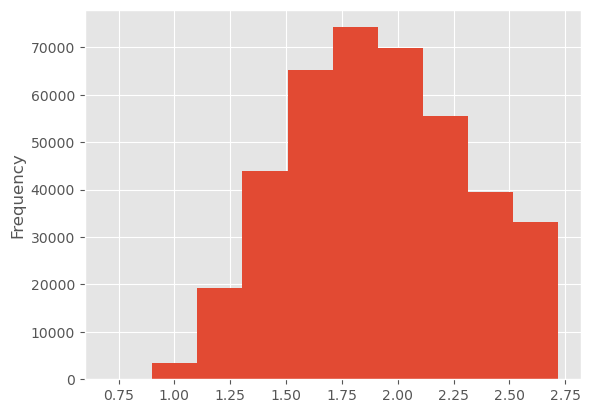

In [25]:
train['cos_sim_exp']= np.exp(train.cos_sim)
train['cos_sim_exp'].plot(kind= 'hist')
plt.show()

In [26]:
# New features
features=['cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'cos_sim_exp', 'cos_sim_tfidf', 'Levenshtein_dist_log', 'fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'longest_substr_ratio']

#### <span style="color:blue">2) SHAPRIO

In [27]:
from scipy.stats import shapiro

for feature in features:
    if shapiro(train[feature]).pvalue<=0.05:
        print(f"{feature} is not normally distributed")
    else:
        print(f"{feature} is normally distributed")

cwc_min is not normally distributed
cwc_max is not normally distributed
csc_min is not normally distributed
csc_max is not normally distributed
ctc_min is not normally distributed
ctc_max is not normally distributed
last_word_eq is not normally distributed
first_word_eq is not normally distributed
cos_sim_exp is not normally distributed
cos_sim_tfidf is not normally distributed
Levenshtein_dist_log is not normally distributed
fuzzy_partial_ratio is not normally distributed
token_sort_ratio is not normally distributed
token_set_ratio is not normally distributed
longest_substr_ratio is not normally distributed


**Based on the Shaprio test none of the variables is normally distributed**

### 2.1.2 Data Normalization

**Normalization does not change the distribution**

In [28]:
train.set_index('id', inplace=True)

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()

X= train[features]
y= train['is_duplicate']

# X_n: normalized X
X_n= scaler.fit_transform(X)
# The output is a numpy array

X_n= pd.DataFrame(X_n, columns= X.columns)
display(X_n.head())

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,cos_sim_exp,cos_sim_tfidf,Levenshtein_dist_log,fuzzy_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
0,0.999984,0.833322,0.999988,0.999988,0.916663,0.785712,0.0,1.0,0.940348,0.895532,0.586230,1.00,1.00,0.93,0.999995
1,0.799987,0.399998,0.749985,0.599991,0.699996,0.466666,0.0,1.0,0.709584,0.474331,0.718889,0.74,0.74,0.63,0.416665
2,0.399994,0.333329,0.399994,0.249998,0.399998,0.285713,0.0,1.0,0.525912,0.225765,0.714686,0.46,0.46,0.63,0.099999
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.312041,0.000000,0.726726,0.11,0.11,0.25,0.083333
4,0.399994,0.199999,0.999955,0.666647,0.571422,0.307691,0.0,1.0,0.363369,0.206084,0.738929,0.55,0.55,0.47,0.142856


### 2.1.3 Feature Selection

    2.1) Random forest feature selection

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
rf.fit(X_n, y)
print(rf.feature_importances_)
print(pd.Series(abs(rf.feature_importances_), index=rf.feature_names_in_).sort_values(ascending=False))

[0.07225115 0.09718113 0.0402072  0.04928179 0.05659825 0.08070335
 0.02627162 0.00904015 0.10748391 0.09113752 0.07604031 0.06859421
 0.07231838 0.08864896 0.06424207]
cos_sim_exp             0.107484
cwc_max                 0.097181
cos_sim_tfidf           0.091138
token_set_ratio         0.088649
ctc_max                 0.080703
Levenshtein_dist_log    0.076040
token_sort_ratio        0.072318
cwc_min                 0.072251
fuzzy_partial_ratio     0.068594
longest_substr_ratio    0.064242
ctc_min                 0.056598
csc_max                 0.049282
csc_min                 0.040207
last_word_eq            0.026272
first_word_eq           0.009040
dtype: float64


### TRAIN THE MODEL WITH ALL THE FEATURES

In [31]:
X_train, X_test, y_train, y_test= train_test_split(X_n, y, test_size=.2, stratify=y, random_state= 123)

In [32]:
log_model= LogisticRegression()
log_model.fit(X_train, y_train)
log_predict= log_model.predict(X_test)
log_predict_proba= log_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=log_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, log_predict_proba)}")

The accuracy of the model is: 0.6985827005367434
The AUC score is: 0.7770768672517622


In [33]:
rf_model= RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predict= rf_model.predict(X_test)
rf_predict_proba= rf_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=rf_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, rf_predict_proba)}") 

The accuracy of the model is: 0.7643894234336739
The AUC score is: 0.8522930565502426


    2.2) Correlation Matrix

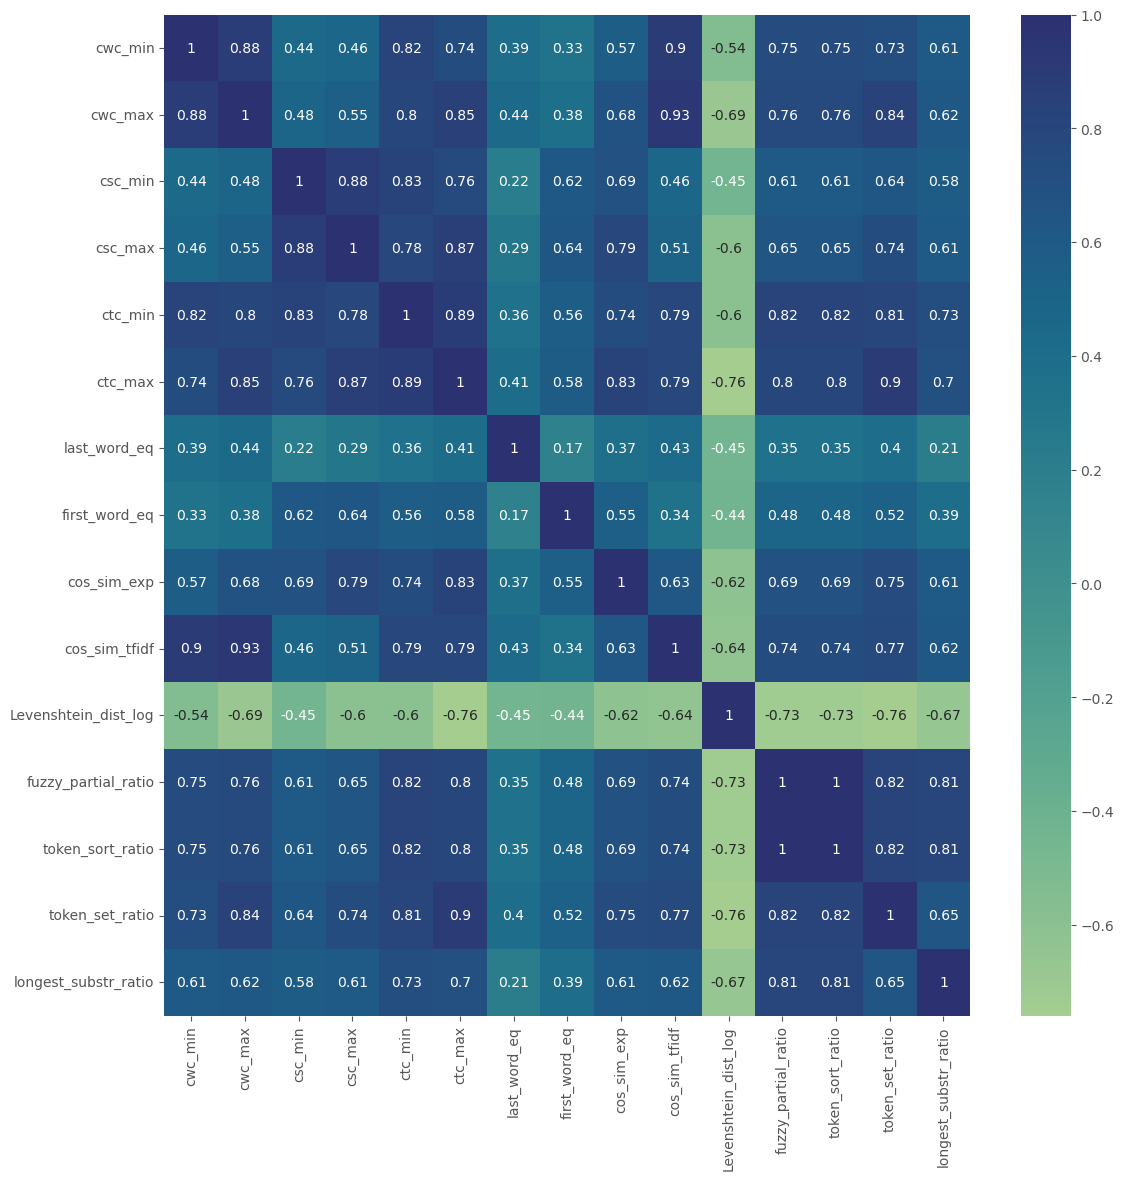

In [34]:
cor_matrix=X_n.corr().round(2)
plt.figure(figsize=(13,13))
sns.heatmap(cor_matrix, annot=True, cmap='crest')
plt.show()

In [35]:
from itertools import combinations

for element in combinations(features,2):
    feature1, feature2= element
    if cor_matrix.loc[feature1, feature2]>0.80:
        print(f"{element[0]} is highly correlated with {element[1]}")

cwc_min is highly correlated with cwc_max
cwc_min is highly correlated with ctc_min
cwc_min is highly correlated with cos_sim_tfidf
cwc_max is highly correlated with ctc_max
cwc_max is highly correlated with cos_sim_tfidf
cwc_max is highly correlated with token_set_ratio
csc_min is highly correlated with csc_max
csc_min is highly correlated with ctc_min
csc_max is highly correlated with ctc_max
ctc_min is highly correlated with ctc_max
ctc_min is highly correlated with fuzzy_partial_ratio
ctc_min is highly correlated with token_sort_ratio
ctc_min is highly correlated with token_set_ratio
ctc_max is highly correlated with cos_sim_exp
ctc_max is highly correlated with token_set_ratio
fuzzy_partial_ratio is highly correlated with token_sort_ratio
fuzzy_partial_ratio is highly correlated with token_set_ratio
fuzzy_partial_ratio is highly correlated with longest_substr_ratio
token_sort_ratio is highly correlated with token_set_ratio
token_sort_ratio is highly correlated with longest_substr_

**Almost all the feature selection techniques are prone to highly correlated features. Therefore, we have to take of the highly correlated features here and keep the ones that make more sense for our analysis**
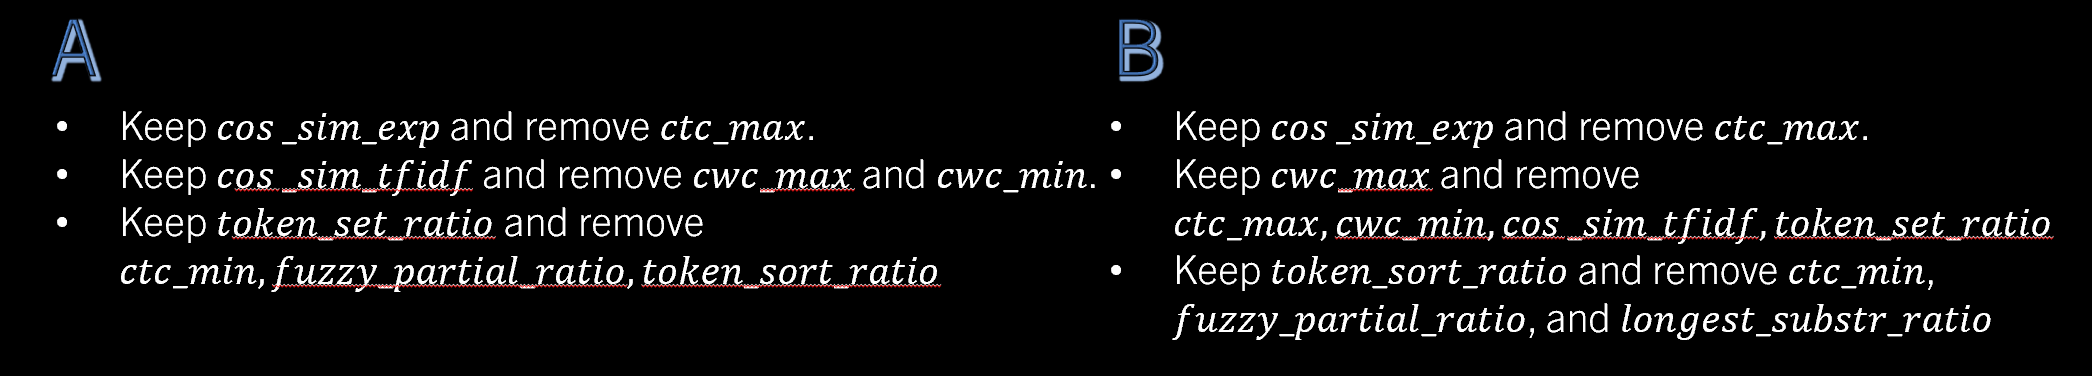


In [36]:
option_a=['cos_sim_exp', 'cos_sim_tfidf', 'cwc_max', 'token_set_ratio', 'Levenshtein_dist_log', 'longest_substr_ratio', 'csc_max', 'last_word_eq', 'first_word_eq']
option_b=['cos_sim_exp', 'cwc_max', 'token_sort_ratio', 'Levenshtein_dist_log', 'csc_max', 'last_word_eq', 'first_word_eq']

In [37]:
X_n_a=X_n[option_a]
X_n_b= X_n[option_b]

    2.3) Remove features with low variance
    
consideration: VarianceThreshold treats features independently.
Recommendation: If there are dependencies or interactions between features that are important for your model, VarianceThreshold might not be the most suitable method.

In [38]:
from sklearn.feature_selection import VarianceThreshold
vt= VarianceThreshold(threshold= 0.001)
selected_features= vt.fit_transform(X_n_a, y)

print(vt.get_feature_names_out(), '\n')

print(f"The values that have variance close to 0: {set.difference(set(option_a), set(vt.get_feature_names_out()))}")

# getfield These are the columns with variance close to zero!

['cos_sim_exp' 'cos_sim_tfidf' 'cwc_max' 'token_set_ratio'
 'Levenshtein_dist_log' 'longest_substr_ratio' 'csc_max' 'last_word_eq'
 'first_word_eq'] 

The values that have variance close to 0: set()


In [39]:
from sklearn.feature_selection import VarianceThreshold
vt= VarianceThreshold(threshold= 0.001)
selected_features= vt.fit_transform(X_n_b, y)

print(vt.get_feature_names_out(), '\n')

print(f"The values that have variance close to 0: {set.difference(set(option_b), set(vt.get_feature_names_out()))}")

# getfield These are the columns with variance close to zero!

['cos_sim_exp' 'cwc_max' 'token_sort_ratio' 'Levenshtein_dist_log'
 'csc_max' 'last_word_eq' 'first_word_eq'] 

The values that have variance close to 0: set()


    2.4) Chi-Squared
    
The Chi-Squared (χ²) test for feature selection is commonly used when dealing with categorical data. This statistical test helps assess the independence between categorical variables. When applying the Chi-Squared test for feature selection, several assumptions and considerations should be kept in mind:

Categorical Data:

Assumption: The data should consist of categorical variables.
Rationale: The Chi-Squared test is designed for categorical data, particularly when analyzing associations between two categorical variables.
Independence:

Assumption: The observations are assumed to be independent.
Rationale: The test evaluates whether observed frequencies differ significantly from expected frequencies under the assumption of independence. Independence is a key assumption for the validity of the Chi-Squared test.
Expected Cell Frequencies:

Consideration: The expected cell frequencies should be reasonably large.
Rationale: For the Chi-Squared test to provide reliable results, the expected frequencies in each cell of the contingency table should not be too small. Low expected frequencies may lead to inaccurate p-values.
Sample Size:

Consideration: The test is sensitive to sample size.
Rationale: With large sample sizes, small deviations from expected frequencies may become statistically significant. It's important to consider both the statistical significance and the practical significance of the results.
Categories in Each Variable:

Consideration: Each variable should have multiple categories.
Rationale: The Chi-Squared test is most informative when variables have more than two categories. For binary variables, other methods like point-biserial correlation or mutual information might be more appropriate.
No Empty Cells:

Consideration: The contingency table should not have empty cells.
Rationale: Empty cells lead to undefined or infinite expected frequencies, making the Chi-Squared test inappropriate.

**THIS IS NOT THE BECT TEST FOR OUR CASE**

In [40]:
from sklearn.feature_selection import chi2, SelectKBest

chi_kbest= SelectKBest(score_func=chi2, k=8)
kbest= chi_kbest.fit_transform(X=X_n_a, y=y)
print(kbest)
chi_kbest.get_feature_names_out()

[[0.9403475  0.89553242 0.83332233 ... 0.999988   0.         1.        ]
 [0.70958395 0.47433071 0.3999976  ... 0.599991   0.         1.        ]
 [0.52591167 0.22576485 0.33332933 ... 0.24999825 0.         1.        ]
 ...
 [0.7496612  1.         0.499977   ... 0.66664733 1.         1.        ]
 [0.41831916 0.         0.         ... 0.0999995  0.         0.        ]
 [0.80674324 1.         0.999971   ... 0.71427957 1.         1.        ]]


array(['cos_sim_exp', 'cos_sim_tfidf', 'cwc_max', 'token_set_ratio',
       'longest_substr_ratio', 'csc_max', 'last_word_eq', 'first_word_eq'],
      dtype=object)

In [41]:
from sklearn.feature_selection import chi2, SelectKBest

chi_kbest= SelectKBest(score_func=chi2, k=7)
kbest= chi_kbest.fit_transform(X=X_n_b, y=y)
print(kbest)
chi_kbest.get_feature_names_out()

[[0.9403475  0.83332233 1.         ... 0.999988   0.         1.        ]
 [0.70958395 0.3999976  0.74       ... 0.599991   0.         1.        ]
 [0.52591167 0.33332933 0.46       ... 0.24999825 0.         1.        ]
 ...
 [0.7496612  0.499977   0.75       ... 0.66664733 1.         1.        ]
 [0.41831916 0.         0.34       ... 0.0999995  0.         0.        ]
 [0.80674324 0.999971   0.89       ... 0.71427957 1.         1.        ]]


array(['cos_sim_exp', 'cwc_max', 'token_sort_ratio',
       'Levenshtein_dist_log', 'csc_max', 'last_word_eq', 'first_word_eq'],
      dtype=object)

    2.5) Recrusive Feature Elimination
    
    Linear Assumption:

Assumption: RFE often assumes a linear relationship between features and the response variable. If the relationship is nonlinear, RFE might not capture it well.

    Multicollinearity Issues:

Limitation: RFE may struggle with multicollinearity (high correlation between features). If features are highly correlated, RFE may not select the most informative subset and might eliminate features arbitrarily.

In [42]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Feature selection
model= LogisticRegression()
rfe= RFECV(estimator= model, min_features_to_select= 5, cv=5)
rfe.fit(X_n_a, y)

print(f"The selected features are: {rfe.get_feature_names_out()}")
print(f"Features ranking: {rfe.ranking_}", '\n')

print(set.difference(set(option_a), set(rfe.get_feature_names_out())))

The selected features are: ['cos_sim_exp' 'cos_sim_tfidf' 'cwc_max' 'token_set_ratio'
 'Levenshtein_dist_log' 'csc_max' 'last_word_eq' 'first_word_eq']
Features ranking: [1 1 1 1 1 2 1 1 1] 

{'longest_substr_ratio'}


In [43]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Feature selection
model= LogisticRegression()
rfe= RFECV(estimator= model, min_features_to_select= 5, cv=5)
rfe.fit(X_n_b, y)

print(f"The selected features are: {rfe.get_feature_names_out()}")
print(f"Features ranking: {rfe.ranking_}", '\n')

print(set.difference(set(option_b), set(rfe.get_feature_names_out())))

The selected features are: ['cos_sim_exp' 'cwc_max' 'token_sort_ratio' 'Levenshtein_dist_log'
 'csc_max' 'last_word_eq' 'first_word_eq']
Features ranking: [1 1 1 1 1 1 1] 

set()


    2.5) Lasso Regression
    
    Multiple Correlated Features:

Limitation: Lasso may arbitrarily choose one among a group of correlated features and drive the coefficients of the others to zero. This can make it less effective when dealing with highly correlated predictors.

    Assumption of Linearity:

Assumption: Like linear regression, Lasso assumes a linear relationship between the features and the response variable. If the true relationship is highly nonlinear, other modeling techniques may be more appropriate.

In [44]:
from sklearn.linear_model import LassoCV
lasso= LassoCV(cv=5)
lasso.fit(X_n_a, y)

print(pd.Series(abs(lasso.coef_), index=lasso.feature_names_in_).sort_values(ascending=False))

print("\n")
lasso.feature_names_in_[abs(lasso.coef_)<0.009]

# first_word_eq be removed based on the Lasso regression model

token_set_ratio         0.609643
Levenshtein_dist_log    0.415166
cwc_max                 0.324980
csc_max                 0.235196
last_word_eq            0.176468
first_word_eq           0.090111
cos_sim_tfidf           0.088172
cos_sim_exp             0.025525
longest_substr_ratio    0.000000
dtype: float64




array(['longest_substr_ratio'], dtype=object)

In [45]:
from sklearn.linear_model import LassoCV
lasso= LassoCV(cv=5)
lasso.fit(X_n_b, y)

print(pd.Series(abs(lasso.coef_), index=lasso.feature_names_in_).sort_values(ascending=False))

print("\n")
lasso.feature_names_in_[abs(lasso.coef_)<0.009]

# first_word_eq be removed based on the Lasso regression model

cwc_max                 0.513114
token_sort_ratio        0.394831
Levenshtein_dist_log    0.387608
last_word_eq            0.180111
csc_max                 0.158599
first_word_eq           0.091823
cos_sim_exp             0.049948
dtype: float64




array([], dtype=object)

### Conclusion

We select option A

### 2.1.5 The final train and test data

In [46]:
X_select= X_n_a

### 2.1.6 Train-Test Split

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cwc_min               404287 non-null  float64
 1   cwc_max               404287 non-null  float64
 2   csc_min               404287 non-null  float64
 3   csc_max               404287 non-null  float64
 4   ctc_min               404287 non-null  float64
 5   ctc_max               404287 non-null  float64
 6   last_word_eq          404287 non-null  int64  
 7   first_word_eq         404287 non-null  int64  
 8   cos_sim_exp           404287 non-null  float64
 9   cos_sim_tfidf         404287 non-null  float64
 10  Levenshtein_dist_log  404287 non-null  float64
 11  fuzzy_partial_ratio   404287 non-null  int64  
 12  token_sort_ratio      404287 non-null  int64  
 13  token_set_ratio       404287 non-null  int64  
 14  longest_substr_ratio  404287 non-null  float64
dtype

In [48]:
X= X_select

# we already have y

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.2, stratify=y, random_state= 123)

Create the train and test datasets

## 2.2 Model Development

### 2.2.1 Try a dummy model and find the accuracy

In [49]:
dummy_model= DummyClassifier(strategy='uniform')
dummy_model.fit(X_train, y_train)
dummy_predict= dummy_model.predict(X_test)
dummy_predict_proba= dummy_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=dummy_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, dummy_predict_proba)}") 
# Which makes sense

The accuracy of the model is: 0.5012243686462687
The AUC score is: 0.5


### Visualization

In [50]:
def create_charts(y_true, y_pred, y_pred_proba):
    fig, ax= plt.subplots(1,2, figsize=(12,5))
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    sns.lineplot(x=fpr, y= tpr, label='ROC curve (area = %0.2f)' % roc_auc, ax= ax[0])
    sns.lineplot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', ax=ax[0])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curve')
    
    # Plot the Confurion Matrix
    conf_matrix= confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=sns.light_palette("blue"), xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax[1])
    ax[1].set_title('Confusion Matrix')
    plt.show()

### 2.2.2 Logistic Regression

In [56]:
log_model= LogisticRegression()
log_model.fit(X_train, y_train)
log_predict= log_model.predict(X_test)
log_predict_proba= log_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=log_predict)}')
print(f'The sensitivity of the model is: {recall_score(y_true=y_test, y_pred=log_predict)}')
print(f'The precision of the model is: {precision_score(y_true=y_test, y_pred=log_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, log_predict_proba)}") 

The accuracy of the model is: 0.6909396720176111
The sensitivity of the model is: 0.4814926473051285
The precision of the model is: 0.601800293070965
The AUC score is: 0.7702935305455314


#### Hyperparameter tuning

In [57]:
# Define the hyperparameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2']  # Regularization penalty
}

grid_search= GridSearchCV(estimator= log_model, param_grid= param_grid, scoring= 'roc_auc', cv= 10)
grid_search.fit(X_train, y_train)
log_model_best= grid_search.best_estimator_
print(f"The parameters are: {grid_search.best_params_}")
log_predict= log_model_best.predict(X_test)
log_predict_proba= log_model_best.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=log_predict)}')
print(f'The sensitivity of the model is: {recall_score(y_true=y_test, y_pred=log_predict)}')
print(f'The precision of the model is: {precision_score(y_true=y_test, y_pred=log_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, log_predict_proba)}") 

The parameters are: {'C': 0.01, 'penalty': 'l2'}
The accuracy of the model is: 0.6907294268965347
The sensitivity of the model is: 0.4728837972733059
The precision of the model is: 0.6036001368223021
The AUC score is: 0.7704456171416131


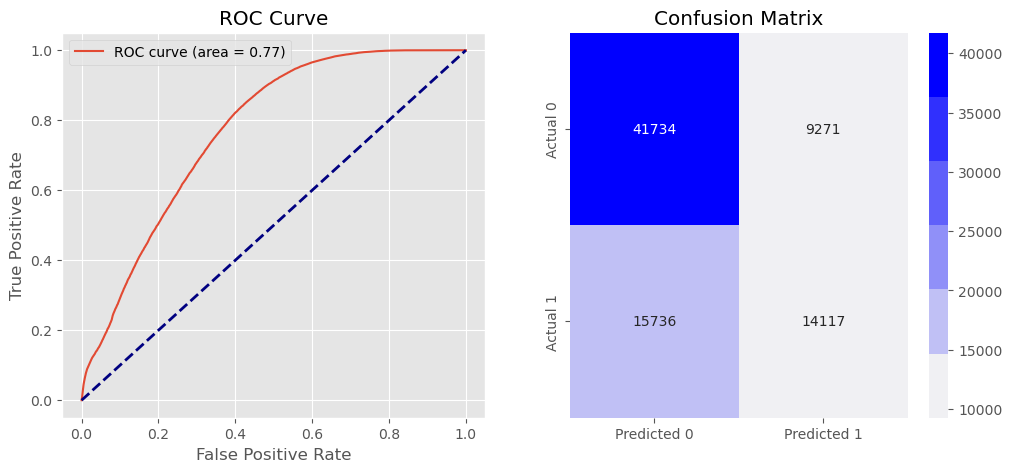

<Figure size 2000x400 with 0 Axes>

In [53]:
create_charts(y_true= y_test, y_pred= log_predict, y_pred_proba= log_predict_proba)

### 2.2.3 Random Forest

In [58]:
rf_model= RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predict= rf_model.predict(X_test)
rf_predict_proba= rf_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=rf_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, rf_predict_proba)}") 

The accuracy of the model is: 0.7573523955576442
The AUC score is: 0.8443078751798919


In [59]:
# Define hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search= GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring= 'roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)
print(f"The parameters are: {grid_search.best_params_}")
best_rf= grid_search.best_estimator_
rf_predict= best_rf.predict(X_test)
rf_predict_proba= best_rf.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=rf_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, rf_predict_proba)}") 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
The parameters are: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 150}
The accuracy of the model is: 0.7610378688565139
The AUC score is: 0.8481273414714947


In [60]:
print(f'The sensitivity of the model is: {recall_score(y_true=y_test, y_pred=rf_predict)}')
print(f'The precision of the model is: {precision_score(y_true=y_test, y_pred=rf_predict)}')

The sensitivity of the model is: 0.69517301443741
The precision of the model is: 0.6699919289749798


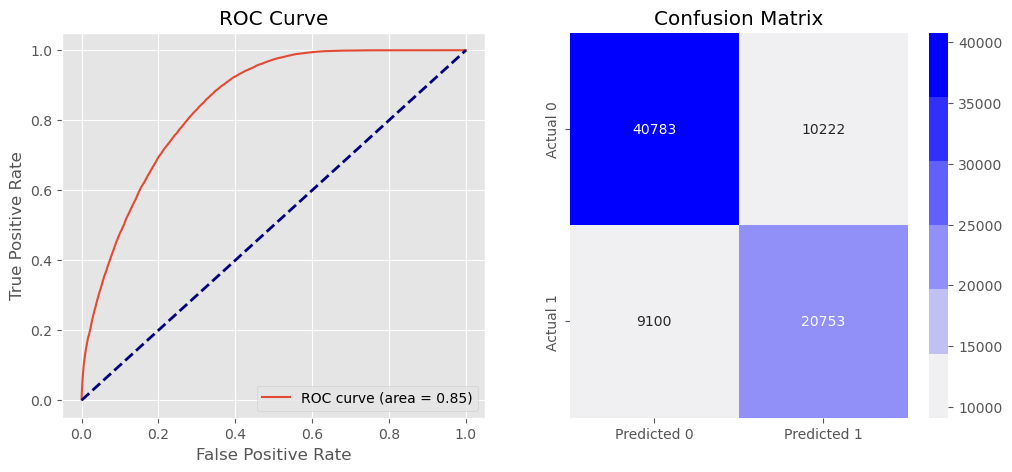

<Figure size 2000x400 with 0 Axes>

In [61]:
create_charts(y_true= y_test, y_pred= rf_predict, y_pred_proba= rf_predict_proba)

### 2.2.5 XGB

In [63]:
import xgboost as xgb
xgb_model= xgb.XGBClassifier(objective= 'binary:logistic', eval_metric= 'auc')
xgb_model.fit(X_train, y_train)
xgb_predict= xgb_model.predict(X_test)
xgb_predict_proba= xgb_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=xgb_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, xgb_predict_proba)}")

The accuracy of the model is: 0.7571668851566945
The AUC score is: 0.8425685259792393


In [64]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search= GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring= 'roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)
best_xgb= grid_search.best_estimator_
xgb_predict= best_xgb.predict(X_test)
xgb_predict_proba= best_xgb.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=xgb_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, xgb_predict_proba)}") 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
The accuracy of the model is: 0.7575255385985308
The AUC score is: 0.8449211731215597


In [65]:
print(f'The sensitivity of the model is: {recall_score(y_true=y_test, y_pred=xgb_predict)}')
print(f'The precision of the model is: {precision_score(y_true=y_test, y_pred=xgb_predict)}')

The sensitivity of the model is: 0.6804341272233946
The precision of the model is: 0.6686526877119062


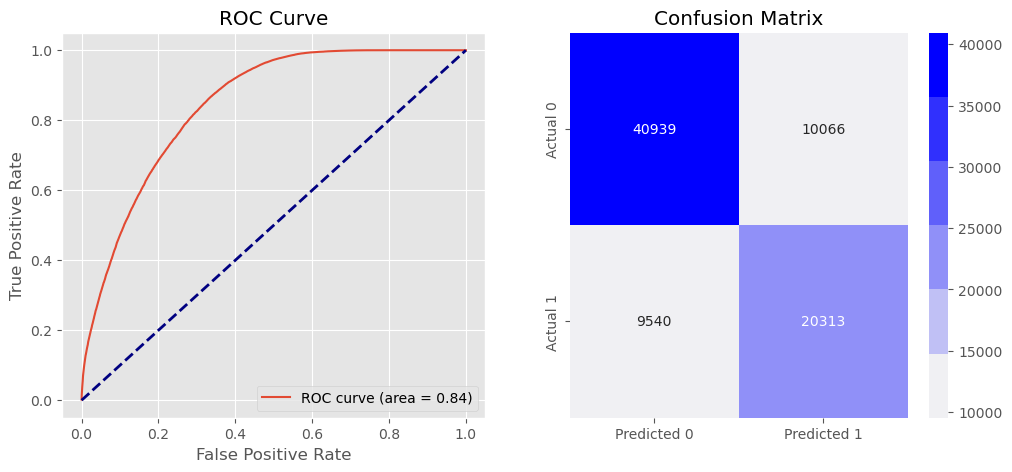

<Figure size 2000x400 with 0 Axes>

In [66]:
create_charts(y_true= y_test, y_pred= xgb_predict, y_pred_proba= xgb_predict_proba)

### 2.2.6 Gaussian Naive Bayes

In [67]:
nb_model= GaussianNB()
nb_model.fit(X_train, y_train)
nb_predict= nb_model.predict(X_test)
nb_predict_proba= nb_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=nb_predict)}')
print(f'The sensitivity of the model is: {recall_score(y_true=y_test, y_pred=nb_predict)}')
print(f'The accuracy of the model is: {precision_score(y_true=y_test, y_pred=nb_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, nb_predict_proba)}")

The accuracy of the model is: 0.6809221103663212
The sensitivity of the model is: 0.6589957458211905
The accuracy of the model is: 0.5574193182784122
The AUC score is: 0.7533200267495086


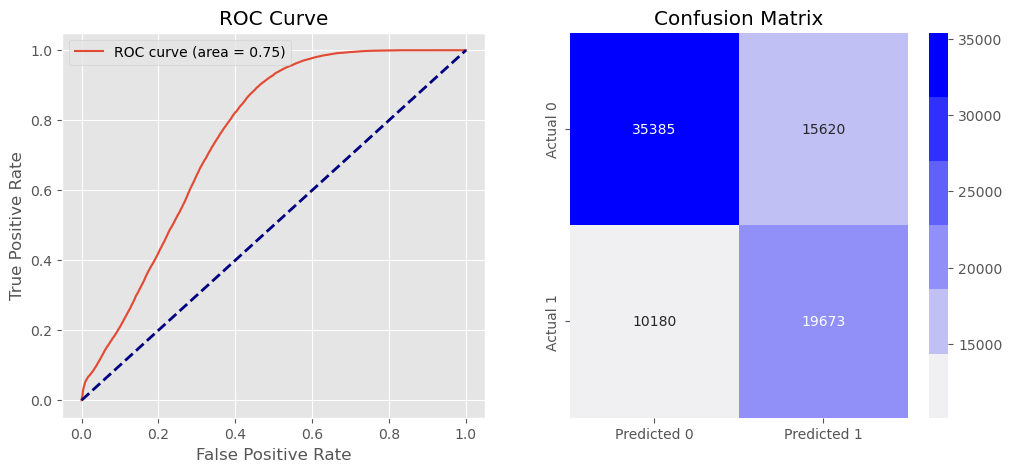

<Figure size 2000x400 with 0 Axes>

In [68]:
create_charts(y_true= y_test, y_pred= nb_predict, y_pred_proba= nb_predict_proba)

### tfidf

### 2.2.7 Logistic Regression-tfidf

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'processed_questions' contains preprocessed text
X = train[['question1', 'question2']]
y = train['is_duplicate']

# Combine 'question1' and 'question2' into a single string for each row
X['combined'] = X['question1'].astype(str) + ' ' + X['question2'].astype(str)

# Handle missing values by filling with an empty string
X['combined'] = X['combined'].fillna('')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X['combined'], y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Ensure the number of samples match
print(X_train_tfidf.shape, '  ', len(X_train))

log_model= LogisticRegression()
log_model.fit(X_train_tfidf, y_train)
log_predict= log_model.predict(X_test_tfidf)
log_predict_proba= log_model.predict_proba(X_test_tfidf)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=log_predict)}')
print(f'The sensitivity of the model is: {recall_score(y_true=y_test, y_pred=log_predict)}')
print(f'The precision of the model is: {precision_score(y_true=y_test, y_pred=log_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, log_predict_proba)}") 

(323429, 77888)    323429
The accuracy of the model is: 0.751329491206807
The sensitivity of the model is: 0.5353311879860553
The precision of the model is: 0.7188836371820841
The AUC score is: 0.8046127182339603


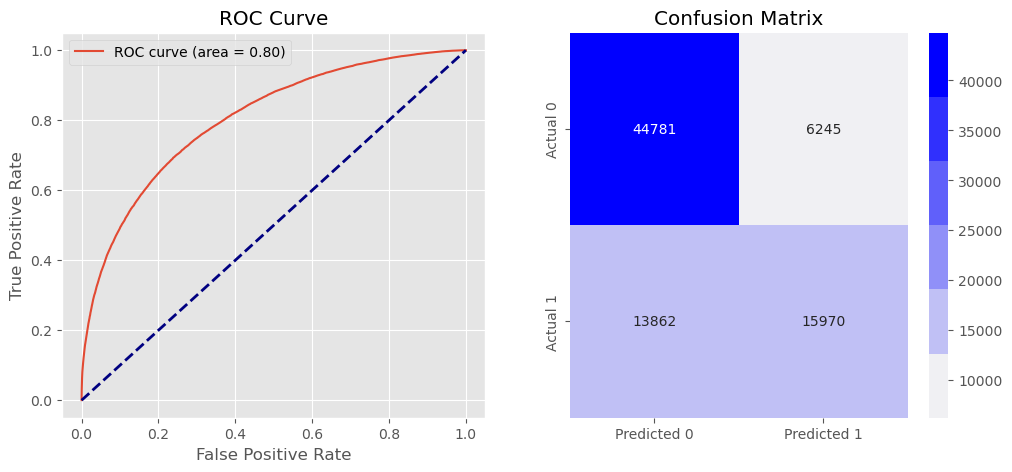

<Figure size 2000x400 with 0 Axes>

In [70]:
create_charts(y_true= y_test, y_pred= log_predict, y_pred_proba= log_predict_proba)

### 2.2.8 Random Forest-tfidf

In [71]:
rf_model= RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_predict= rf_model.predict(X_test_tfidf)
rf_predict_proba= rf_model.predict_proba(X_test_tfidf)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=rf_predict)}')
print(f'The sensitivity of the model is: {recall_score(y_true=y_test, y_pred=rf_predict)}')
print(f'The precision of the model is: {precision_score(y_true=y_test, y_pred=rf_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, rf_predict_proba)}") 

The accuracy of the model is: 0.8127334339211952
The sensitivity of the model is: 0.6888576025744167
The precision of the model is: 0.7781143506247633
The AUC score is: 0.8700353477796781


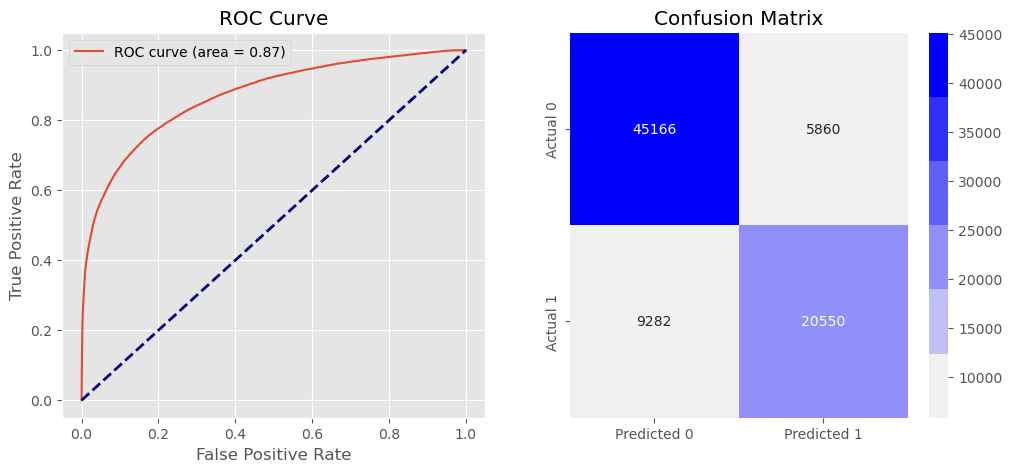

<Figure size 2000x400 with 0 Axes>

In [72]:
create_charts(y_true=y_test, y_pred= rf_predict, y_pred_proba=rf_predict_proba)

### 2.2.9 XGB-tfidf

In [73]:
xgb_model.fit(X_train_tfidf, y_train)
xgb_predict= xgb_model.predict(X_test_tfidf)
xgb_predict_proba= xgb_model.predict_proba(X_test_tfidf)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=xgb_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, xgb_predict_proba)}")

The accuracy of the model is: 0.7355487397660095
The AUC score is: 0.7943927911537367


In [75]:
print(f'The sensitivity of the model is: {recall_score(y_true=y_test, y_pred=xgb_predict)}')
print(f'The precision of the model is: {precision_score(y_true=y_test, y_pred=xgb_predict)}')

The sensitivity of the model is: 0.3994703673907214
The precision of the model is: 0.7745856353591161


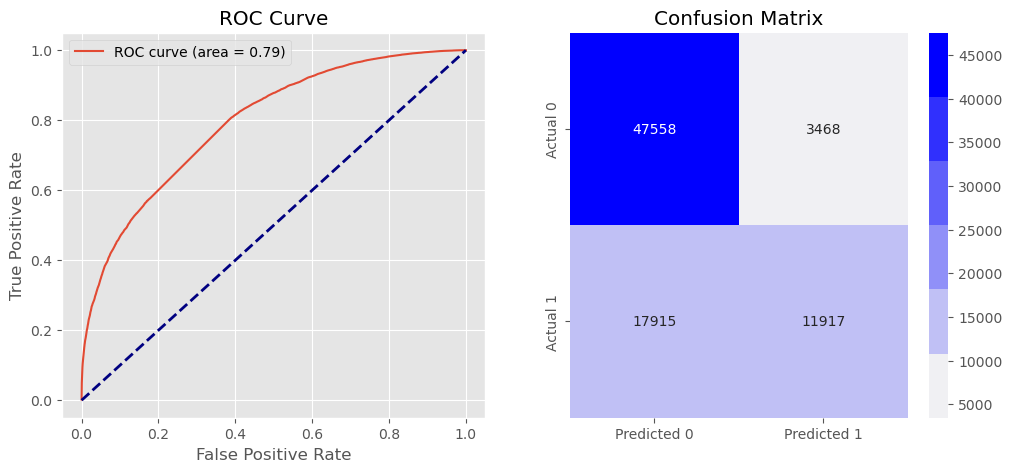

<Figure size 2000x400 with 0 Axes>

In [74]:
create_charts(y_true=y_test, y_pred= xgb_predict, y_pred_proba=xgb_predict_proba)

## Conclusion and Future Improvement

- Models developed using tfidf vectors were found to have better predictive performance compared to those that were developed using the user-defined factors
- Using the proposed models, the website can label the question pairs as either duplicated or non-duplicated
- The models help with providing answers instantly to questions that have already been answered
- This will help the responders to build on the previous responses and avoid duplicated answers to the same questions.

- Building models based on transformers such as BERT might lead to better results.